## Table of Contents
1. ### [Baseline](#baseline)<br>
    1.1  [Read the file](#ReadFile)<br>
    1.2  [Explore Data](#ExploreData)<br>
    1.2  [Visualize Data](#VisualizeData)<br>
    1.4  [Engineer Features](#FeatureEngineering)<br>
    1.5  [Handle Outliers](#HandleOutliers)<br>
    1.6 [Heatmap Visualization](#heatmap)<br>
    1.7 [Feature Selection Initial Exploration](#featureselectioninitial)<br>
    1.8 [Basic Model Comparison](#CompareBasicModels)<br>
    1.9 [Does clipping CreditScore and Age give better results?](#ExtraClipping)<br>
    1.10 [Model Comparison With Smote](#CompareBasicModelsWithSmote)<br>
#### [Hyper Parameter Optimization](#hyperparamoptimize)<br>
    1.11 [Grid Search Gradient Boost](#GridSearchGradientBoost)<br>
    1.12 [Grid Search Random Forest](#GridSearchRandomForest)<br>
    1.13 [Grid Search Support Vector Classifier](#GridSearchSVC)<br>
    1.14 [Grid Search Multi-Layer Perceptrons](#GridSearchMLP)<br>
    1.15 [Final Baseline](#FinalBaseline)<br>
2. ### [Basic Experimentation](#BasicExperimentation)<br>
    2.1 [Are there any outliers detected by Random Forest?](#RandomForestBasicCount)<br>
    2.2 [Feature Selection, PCA, SVC](#SVC_FS_PCA)<br>
    2.3 [Feature Selection, Random Fores](#RF_FS)<br>
    2.4 [Compare Feature Selection Methods](#CMP_FS)<br>
    2.5 [Check if MinMaxScaling makes a difference](#BEMMS)<br>
    2.6 [Add PCA to the mix](#BEPCA)<br>
3. ### [Research Section](#ResearchSection)<br>
    3.1 [Experimentation with Weighted-Features in Random Forest](#RFCWeightedFeatures)<br>
    3.2 [Grid Search different weights (no SMOTE)](#GridSearchRFCWeighted)<br>
    3.3 [GridSearch BalancedRandomForestClassifier from Imblearn](#GSBalancedRFC)<br>
    3.4 [Random Forest with Adjusted Cutoff](#RFAdjustedCutoff)<br>
    3.5 [Classification with Other Samplers (over-samplers and combine-samplers)](#ClassificationSamplerComparison)<br>
    3.6 [Classifiers Samplers and Feature-Selectors compared](#ClassifierSamplerSelectorCompared)<br>
    3.7 [RUSBoost (Boost + UnderSampling at each stage)](#rusboost)<br>

In [235]:
%matplotlib inline

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics, model_selection
from statistics import mean, median
from time import perf_counter
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import NearestCentroid
import imblearn
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SMOTENC, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
import random
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import linear_model
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFwe, chi2, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier

In [236]:
plt.rcParams['figure.figsize'] = [12, 8]

#### Read the file <a class='anchor' id='ReadFile'></a>

In [216]:
def read_file()->pd.DataFrame:
    df = pd.read_csv('Churn_Modelling.csv')
    df.describe()
    return df
df = read_file()

### Baseline <a class='anchor' id='baseline'></a>

### Explore the data <a class='anchor' id='ExploreData'></a>

In [217]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [219]:
df.describe().T

count          mean           std          min  \
RowNumber        10000.0  5.000500e+03   2886.895680         1.00   
CustomerId       10000.0  1.569094e+07  71936.186123  15565701.00   
CreditScore      10000.0  6.505288e+02     96.653299       350.00   
Age              10000.0  3.892180e+01     10.487806        18.00   
Tenure           10000.0  5.012800e+00      2.892174         0.00   
Balance          10000.0  7.648589e+04  62397.405202         0.00   
NumOfProducts    10000.0  1.530200e+00      0.581654         1.00   
HasCrCard        10000.0  7.055000e-01      0.455840         0.00   
IsActiveMember   10000.0  5.151000e-01      0.499797         0.00   
EstimatedSalary  10000.0  1.000902e+05  57510.492818        11.58   
Exited           10000.0  2.037000e-01      0.402769         0.00   

                         25%           50%           75%          max  
RowNumber            2500.75  5.000500e+03  7.500250e+03     10000.00  
CustomerId       15628528.25  1.569074e+07  1.575323e+07  15815690.00  
CreditScore           584.00  6.520000e+02  7.180000e+02       850.00  
Age                    32.00  3.700000e+01  4.400000e+01        92.00  
Tenure                  3.00  5.000000e+00  7.000000e+00        10.00  
Balance                 0.00  9.719854e+04  1.276442e+05    250898.09  
NumOfProducts           1.00  1.000000e+00  2.000000e+00         4.00  
HasCrCard               0.00  1.000000e+00  1.000000e+00         1.00  
IsActiveMember          0.00  1.000000e+00  1.000000e+00         1.00  
EstimatedSalary     51002.11  1.001939e+05  1.493882e+05    199992.48  
Exited                  0.00  0.000000e+00  0.000000e+00         1.00

#### Check if there are any missing values

In [220]:
df.isnull().sum(axis=0)

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There are no missing values that we need to deal with here

#### Visualize the data <a class='anchor' id='VisualizeData'></a>

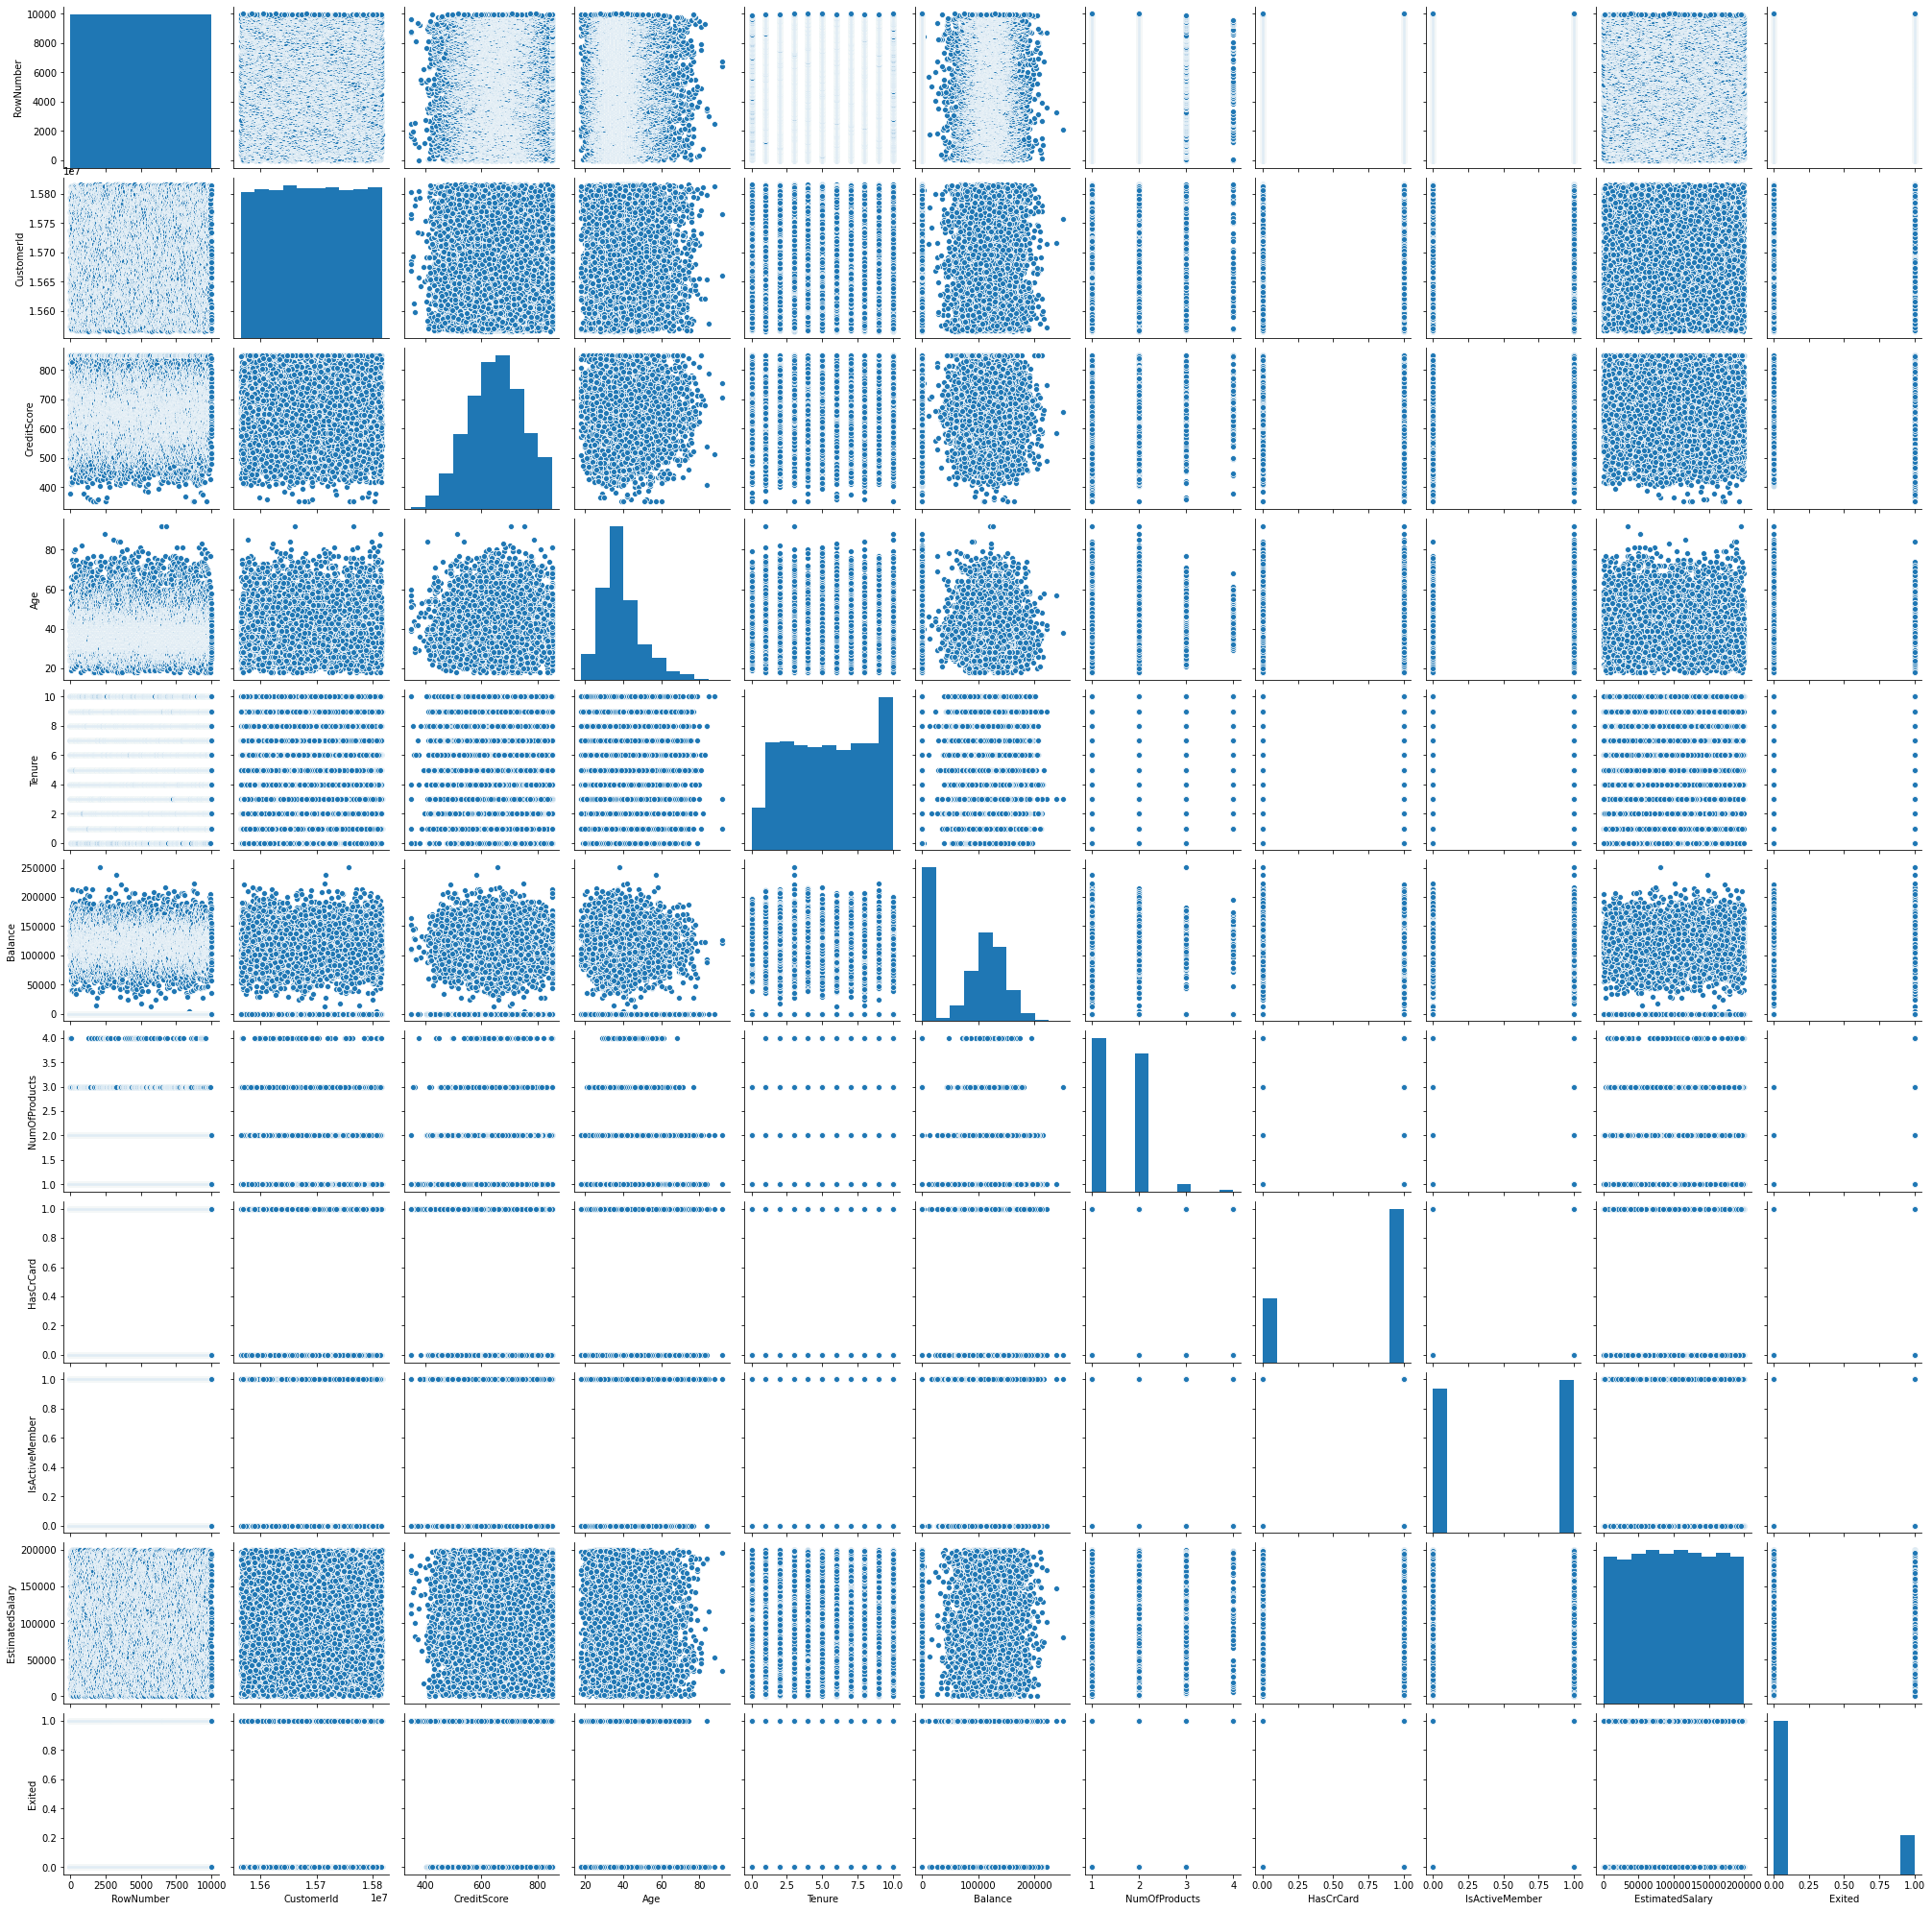

In [221]:
sns.pairplot(df)
plt.show()

#### Feature Engineering <a class='anchor' id='FeatureEngineering'></a>

##### Drop columns we know from experience that are irrelevant, One Hot Encoding, Standardization

We can straight away drop Surname, CustomerId, RowNumber without checking anything because we know that these don't have any bearing on the churn rate. Furthermore, including Surname might actually add discrimination based on race etc.

The next step is to one-hot encode Gender and Geography.

The last step is to normalize some of the fields which have numbers.

Scaling is done before outlier handling because once scaling is done, it will allow us to plot the box plots at one go in a single graph. Scaling doesn't affect the frequency distribution and outlier detection.


In [222]:
def engineer_features(df: pd.DataFrame, donot_scale=False)->tuple:
    ohdf = df.drop(columns=['RowNumber', 'Surname', 'CustomerId'])
    ohdf.describe()
    X, y = ohdf[ohdf.columns[:-1]], ohdf[df.columns[-1]]
    X = pd.get_dummies(X, columns=['Gender', 'Geography'], dummy_na=False)
    scaled_X = X.copy()
    columns_to_transform = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    if not donot_scale:
        scaled_X[columns_to_transform] = StandardScaler().fit_transform(scaled_X[columns_to_transform])
    return X, scaled_X, y
X, scaled_X, y = engineer_features(df)

In [223]:
def engineer_features2(df: pd.DataFrame)->tuple:
    ohdf = df.drop(columns=['RowNumber', 'Surname', 'CustomerId'])
    X = pd.get_dummies(ohdf, columns=['Gender', 'Geography'], dummy_na=False)
    return X

#### Handle Outliers <a class='anchor' id='HandleOutliers'></a>

If any outliers are present, they must be removed. The way to check for outliers is to 

[Text(0, 0, 'CreditScore'),
 Text(1, 0, 'Age'),
 Text(2, 0, 'Tenure'),
 Text(3, 0, 'Balance'),
 Text(4, 0, 'NumOfProducts'),
 Text(5, 0, 'EstimatedSalary')]

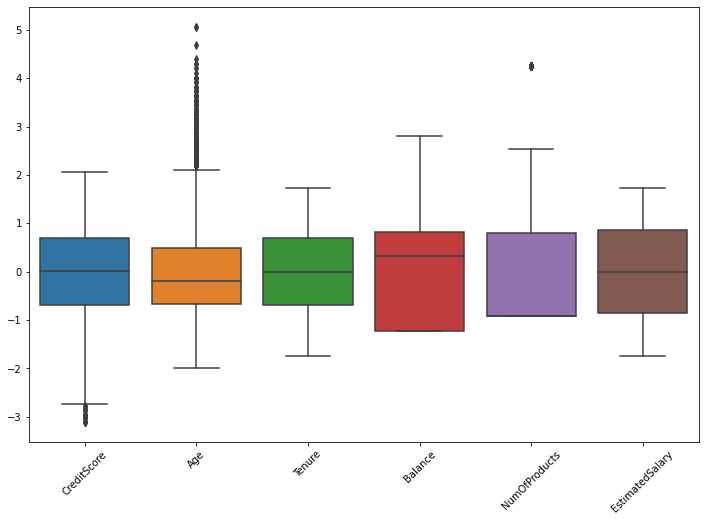

In [224]:
ax = sns.boxplot(data=scaled_X[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

**Clip NumOfProducts to [mean - 1.5 * IQR, mean + 1.5 * IQR]**

NumOfProducts is has outliers which are beyond the whiskers

[Text(0, 0, 'CreditScore'),
 Text(1, 0, 'Age'),
 Text(2, 0, 'Tenure'),
 Text(3, 0, 'Balance'),
 Text(4, 0, 'NumOfProducts'),
 Text(5, 0, 'EstimatedSalary')]

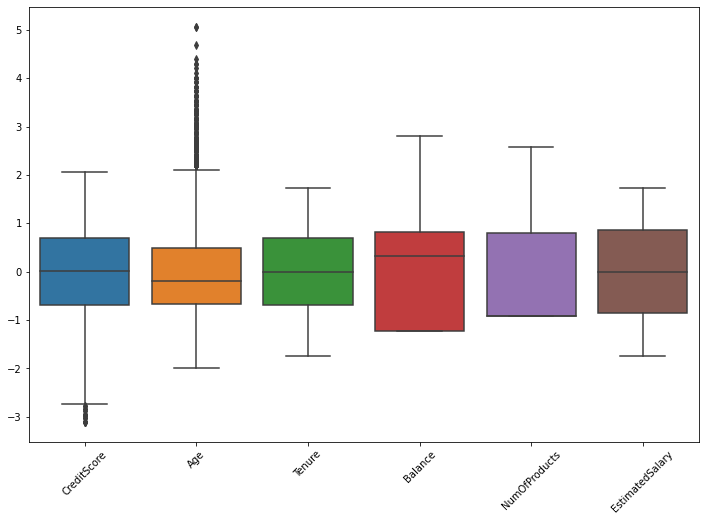

In [225]:
q1 = scaled_X['NumOfProducts'].quantile(0.25)
q3 = scaled_X['NumOfProducts'].quantile(0.75)
avg = scaled_X['NumOfProducts'].mean()
iqr = q3 - q1
themin, themax = avg - 1.5 * iqr, avg + 1.5 * iqr
scaled_X[['NumOfProducts']] = scaled_X[['NumOfProducts']].clip(themin, themax)
ax = sns.boxplot(data=scaled_X[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

_**While there are some outliers here in CreditScore and Age, we will choose to let them remain as all these values form a continuum and touch the whiskers.**_

#### Visualize the Data as a heatmap <a class='anchor' id='heatmap'></a>

<AxesSubplot:>

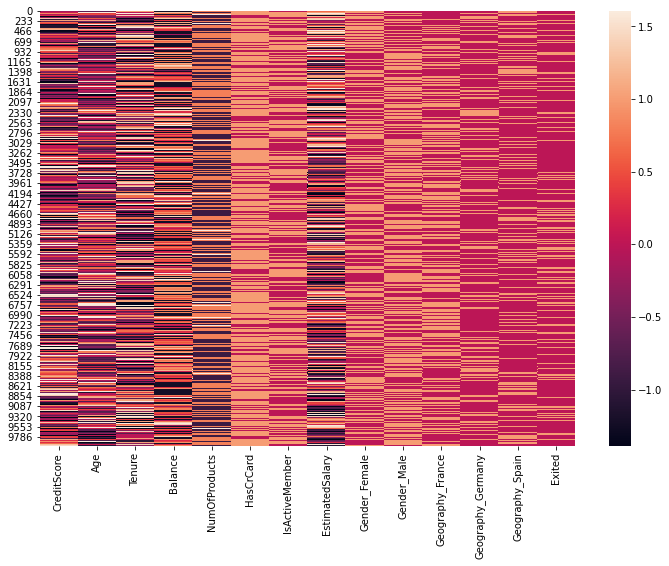

In [226]:
sns.heatmap(pd.concat([scaled_X, y], axis=1), robust=True)

As we can see the Exited field is unbalanced
Print the number of instances of each class

In [227]:
tc = 0
fc = 0
for i in y==1:
    if True == i:
        tc += 1
    else:
        fc += 1
print(f"Exited: 1 = {tc}, 0 = {fc}")

Exited: 1 = 2037, 0 = 7963


### Feature Selection Initial Exploration <a class='anchor' id='featureselectioninitial'></a>

#### Check _univariate feature selection_ first
We know that this will be biased against categorical values, but we'll see this anyway

In [228]:
def feature_selection_with_select_percentile():
    selector = SelectPercentile(f_classif, percentile=25)
    selector.fit(scaled_X, y)
    print('-' * 120)
    print("%40s ------- %10s" % ('Feature', 'Score'))
    print('-' * 120)
    sorted_indices = np.argsort(selector.scores_)[::-1]
    for i in sorted_indices:
        print("%40s ------- %10.5f" % (scaled_X.columns[i], selector.scores_[i]))
    print('-' * 120)
    return selector
selector = feature_selection_with_select_percentile()

------------------------------------------------------------------------------------------------------------------------
                                 Feature -------      Score
------------------------------------------------------------------------------------------------------------------------
                                     Age -------  886.06327
                       Geography_Germany -------  310.25838
                          IsActiveMember -------  249.80079
                                 Balance -------  142.47383
                           Gender_Female -------  114.72799
                             Gender_Male -------  114.72799
                        Geography_France -------  111.36052
                           NumOfProducts -------   49.28413
                         Geography_Spain -------   27.80947
                             CreditScore -------    7.34452
                                  Tenure -------    1.96016
                         EstimatedSala

#### Also check the _Tree based feature selector_ to see which features are better

In [15]:
def feature_selection_with_random_forest():
    forest = RandomForestClassifier(n_estimators=250, random_state=0)
    forest.fit(scaled_X, y)
    sorted_indices = np.argsort(forest.feature_importances_)[::-1]
    print('-' * 120)
    print("%40s ------- %10s" % ('Feature', 'Importance'))
    print('-' * 120)
    for i in sorted_indices:
        print("%40s ------- %10.5f" % (scaled_X.columns[i], forest.feature_importances_[i]))
    print('-' * 120)
    return forest
forest = feature_selection_with_random_forest()

------------------------------------------------------------------------------------------------------------------------
                                 Feature ------- Importance
------------------------------------------------------------------------------------------------------------------------
                                     Age -------    0.24002
                         EstimatedSalary -------    0.14694
                             CreditScore -------    0.14569
                                 Balance -------    0.14112
                           NumOfProducts -------    0.12829
                                  Tenure -------    0.08314
                          IsActiveMember -------    0.04043
                       Geography_Germany -------    0.02082
                               HasCrCard -------    0.01836
                        Geography_France -------    0.00993
                         Geography_Spain -------    0.00855
                           Gender_Fema

#### Also see _Greedy feature selection_ to see what it gives us

In [16]:
def feature_selection_with_svc():
    svm = SVC()
    scores = model_selection.cross_val_score(svm, scaled_X, y, cv=10)
    print('Initial Results', scores.mean())

    estimator = linear_model.LogisticRegression(multi_class='auto', solver='lbfgs')
    rfecv = RFECV(estimator, cv=10)
    rfecv.fit(scaled_X, y)
    sorted_indices = np.argsort(rfecv.ranking_)
    print(rfecv.n_features_)
    print('-' * 120)
    print("%40s ------- %10s" % ('Feature', 'Ranking'))
    print('-' * 120)
    for i in sorted_indices:
        print("%40s ------- %10.5f" % (scaled_X.columns[i], rfecv.ranking_[i]))
    print('-' * 120)
    return rfecv
rfecv = feature_selection_with_svc()

Initial Results 0.858
4
------------------------------------------------------------------------------------------------------------------------
                                 Feature -------    Ranking
------------------------------------------------------------------------------------------------------------------------
                                     Age -------    1.00000
                          IsActiveMember -------    1.00000
                             Gender_Male -------    1.00000
                       Geography_Germany -------    1.00000
                        Geography_France -------    2.00000
                         Geography_Spain -------    3.00000
                           Gender_Female -------    4.00000
                                 Balance -------    5.00000
                           NumOfProducts -------    6.00000
                             CreditScore -------    7.00000
                                  Tenure -------    8.00000
              

------------------------------------------------------------------------------------------------------------------------
                                 Feature ------------------      Score Importance    Ranking
------------------------------------------------------------------------------------------------------------------------
                             CreditScore ------------------        7.3      0.146          7
                                     Age ------------------      886.1      0.240          1
                                  Tenure ------------------        2.0      0.083          8
                                 Balance ------------------      142.5      0.141          5
                           NumOfProducts ------------------       49.3      0.128          6
                               HasCrCard ------------------        0.5      0.018          9
                          IsActiveMember ------------------      249.8      0.040          1
              

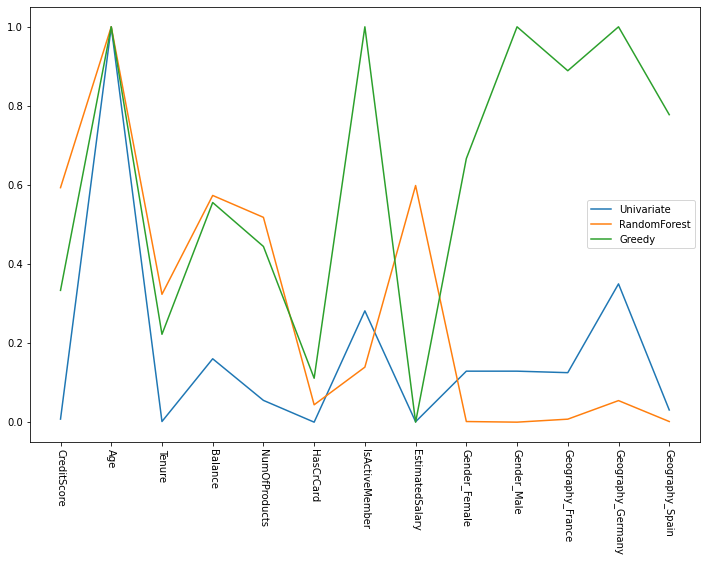

In [17]:
"""Plot all the three methods of feature selection in the same graph. Normalize the scores
so that they are all int he same scale
"""
def get_normalized(a: list):
    """
    Normalizes a list to [0,1]
    """
    themin = min(a)
    themax = max(a)
    ret = []
    print(a, type(a))
    for i in a:
        ret.append((i - themin) / (themax - themin))
    return ret

print('-' * 120)
print("%40s ------------------ %10s %10s %10s" % ('Feature', 'Score', 'Importance', 'Ranking'))
print('-' * 120)
for i, j, k, l in zip(scaled_X.columns, selector.scores_, forest.feature_importances_, rfecv.ranking_):
    print("%40s ------------------ %10.1f %10.3f %10d" % (i, j, k, l))
print('-' * 120)
fig, ax = plt.subplots()
ax.plot(get_normalized(selector.scores_), label='Univariate')
ax.plot(get_normalized(forest.feature_importances_), label='RandomForest')
rf_ranking_inv = [max(rfecv.ranking_) - i for i in rfecv.ranking_]
ax.plot(get_normalized(rf_ranking_inv), label='Greedy')
plt.xticks(np.arange(0, len(scaled_X.columns), 1.0))
ax.set_xticklabels(scaled_X.columns, rotation=270)
ax.legend()

**With all the features, using the three different methods to see which features are noisy, we don't get any clear indication about which features are important and which are not.**

HasCrCard is probably not important, but even that is not very clear, so we'll let things be.

On the other hand, we know that Age, Balance, and IsActiveMember are probably very important.

#### Compare Basic Models   <a class='anchor' id='CompareBasicModels'></a>

In [ ]:
import warnings; warnings.simplefilter('ignore')


def compare_basic_models(run_fn, test_models=None, no_sort=False)->None:
    """
    Run models against the data, compare them according to F1 and Accuracy
    It accepts a function to run which decides the pipeline. This is for reuse.
    """
    basic_models = [
        ('DecisionTreeClassifier', lambda: DecisionTreeClassifier(random_state=1)),
        ('KNeighborsClassifier', lambda: KNeighborsClassifier()),
        ('NearestCentroid', lambda: NearestCentroid()),
        ('NaiveBayes', lambda: GaussianNB()),
        #('Gaussian Process', lambda: GaussianProcessClassifier(random_state=1)),
        ('Support Vector Machines', lambda: SVC(random_state=1)),
        ('Random Forest', lambda: RandomForestClassifier(random_state=1)),
        ('Ada Boost', lambda: AdaBoostClassifier(random_state=1)),
        ('Gradient Boost', lambda: GradientBoostingClassifier()),
        ('Linear Discriminant Analysis', lambda: LinearDiscriminantAnalysis()),
        ('Quadriatic Discriminant Analysis', lambda: QuadraticDiscriminantAnalysis()),
        ('Logistic Regression', lambda: LogisticRegression(random_state=1)),
        ('Ridge Classifier', lambda: RidgeClassifier(random_state=1)),
        ('Bagging Classifier', lambda: BaggingClassifier(random_state=1)),
        ('SGD Classifier', lambda: SGDClassifier(random_state=1)),
        ('Passive Aggressive Classifier', lambda: PassiveAggressiveClassifier(random_state=1)),
        ('Perceptron', lambda: Perceptron(random_state=1)),
        ('Multi-Layer Perceptron', lambda: MLPClassifier(random_state=1))
    ]
    if None != test_models:
        basic_models = test_models
    accuracy_scores = []
    f1_scores = []
    models = []
    run_times = []
    
    # Run all the models
    for name, fn in basic_models:
        print(name, fn)
        t1 = perf_counter()
        acc, f1 = run_fn(scaled_X, y, fn)
        run_times.append(perf_counter() - t1)
        accuracy_scores.append(acc)
        f1_scores.append(f1)
        models.append(name)
        
    # Rest of the code is just to plot a graph
    fig, ax = plt.subplots()
    min_times = min(run_times)
    max_times = max(run_times)
    if len(run_times) > 1:
        for i in range(len(run_times)):
            run_times[i] = (run_times[i] - min_times) / (max_times - min_times)
    sorted_indices = np.argsort(f1_scores) # Sort by f1 score
    if no_sort:
        sorted_indices = [i for i in range(len(f1_scores))]
    ax.plot(range(len(run_times)), [run_times[i] for i in sorted_indices], label="run_time")
    ax.plot(range(len(accuracy_scores)), [accuracy_scores[i] for i in sorted_indices],  label="accuracy")
    ax.plot(range(len(f1_scores)), [f1_scores[i] for i in sorted_indices],  label="f1 score")
    plt.xticks(np.arange(0, len(accuracy_scores), 1.0))
    ax.set_xticklabels([models[i] for i in sorted_indices], rotation=270)
    fig.legend()
    
    print('-' * 120)
    print("%40s  ----   %10s %10s %10s" % ('Model', 'Accuracy', 'F1 Score', 'Run Time'))
    print('-' * 120)
    for i in sorted_indices:
        print("%40s  ----   %10.3f %10.3f %10.3f" % (models[i], accuracy_scores[i], f1_scores[i], run_times[i]))
    print('-' * 120)
    return None


In [ ]:
def run_basic_model(X:pd.DataFrame, y:pd.DataFrame, model_gen_fn):
    kf = model_selection.StratifiedKFold(n_splits=6, shuffle=True, random_state=5)
    accuracy_scores = []
    f1_scores = []
    for train_index, val_index in kf.split(X, y):
        clf = model_gen_fn()
        clf.fit(X.to_numpy()[train_index], y.to_numpy()[train_index])
        y_pred = clf.predict(X.to_numpy()[val_index])
        y_true = y.to_numpy()[val_index]
        accuracy_scores.append(metrics.accuracy_score(y_true, y_pred))
        f1_scores.append(metrics.f1_score(y_true, y_pred))
    #print(median(accuracy_scores), median(f1_scores))
    return mean(accuracy_scores), mean(f1_scores)

DecisionTreeClassifier <function compare_basic_models.<locals>.<lambda> at 0x000001D921C8B1F0>
KNeighborsClassifier <function compare_basic_models.<locals>.<lambda> at 0x000001D921C8B3A0>
NearestCentroid <function compare_basic_models.<locals>.<lambda> at 0x000001D85A6FC9D0>
NaiveBayes <function compare_basic_models.<locals>.<lambda> at 0x000001D85C113B80>
Support Vector Machines <function compare_basic_models.<locals>.<lambda> at 0x000001D85C0DA940>
Random Forest <function compare_basic_models.<locals>.<lambda> at 0x000001D85C0DAA60>
Ada Boost <function compare_basic_models.<locals>.<lambda> at 0x000001D85FCC9040>
Gradient Boost <function compare_basic_models.<locals>.<lambda> at 0x000001D921DB81F0>
Linear Discriminant Analysis <function compare_basic_models.<locals>.<lambda> at 0x000001D921DB8040>
Quadriatic Discriminant Analysis <function compare_basic_models.<locals>.<lambda> at 0x000001D921DB80D0>
Logistic Regression <function compare_basic_models.<locals>.<lambda> at 0x000001D921

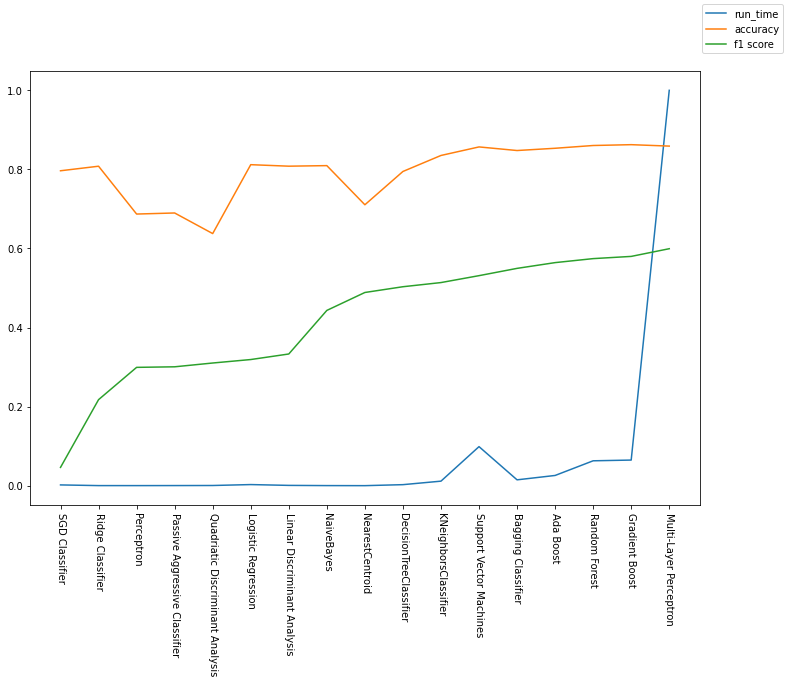

In [230]:
compare_basic_models(run_basic_model)

### Does clipping CreditScore and Age give better results?  <a class='anchor' id='ExtraClipping'></a>

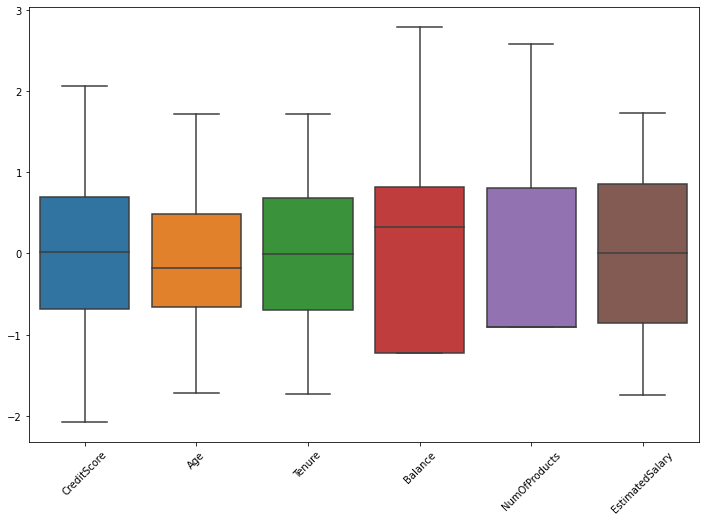

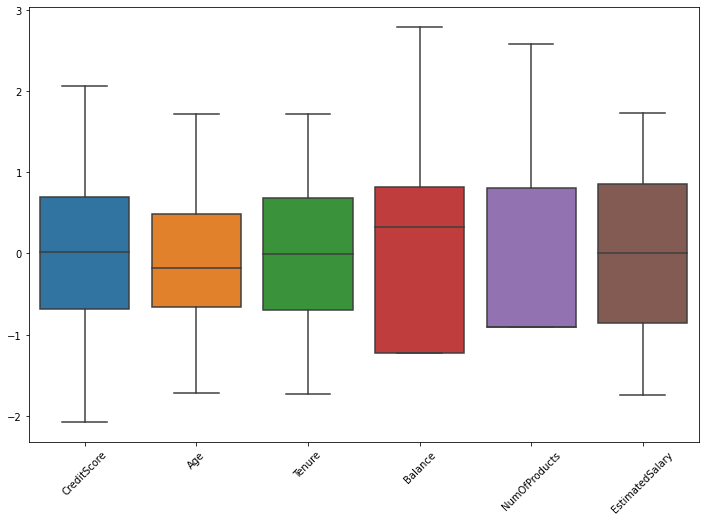

DecisionTreeClassifier <function compare_basic_models.<locals>.<lambda> at 0x000001D921ED7550>
KNeighborsClassifier <function compare_basic_models.<locals>.<lambda> at 0x000001D85C0DAA60>
NearestCentroid <function compare_basic_models.<locals>.<lambda> at 0x000001D92285CEE0>
NaiveBayes <function compare_basic_models.<locals>.<lambda> at 0x000001D92285CE50>
Support Vector Machines <function compare_basic_models.<locals>.<lambda> at 0x000001D92285CF70>
Random Forest <function compare_basic_models.<locals>.<lambda> at 0x000001D926084160>
Ada Boost <function compare_basic_models.<locals>.<lambda> at 0x000001D9260841F0>
Gradient Boost <function compare_basic_models.<locals>.<lambda> at 0x000001D926084280>
Linear Discriminant Analysis <function compare_basic_models.<locals>.<lambda> at 0x000001D926084310>
Quadriatic Discriminant Analysis <function compare_basic_models.<locals>.<lambda> at 0x000001D9260843A0>
Logistic Regression <function compare_basic_models.<locals>.<lambda> at 0x000001D926

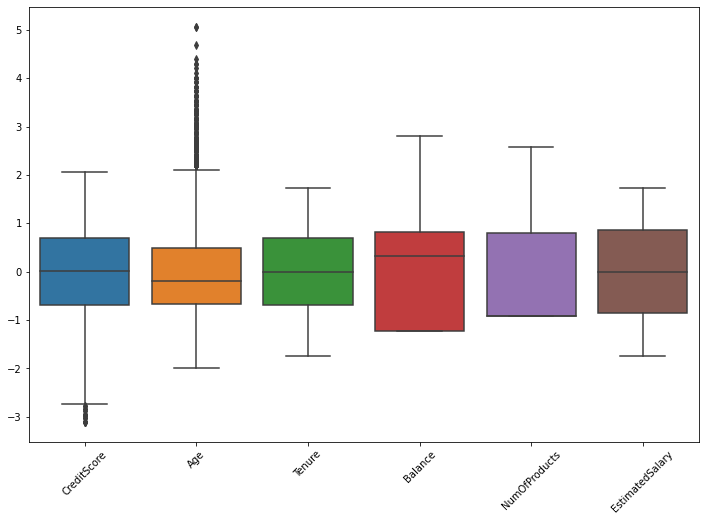

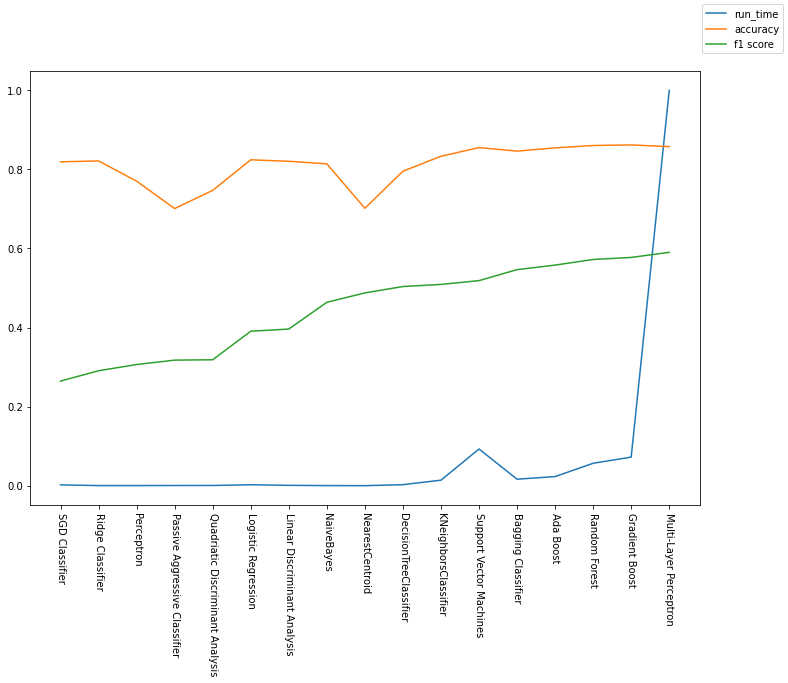

In [231]:
# First clip the two fields Age and CreditScore, and see if it gives better results
ax = sns.boxplot(data=temp_scaled_X[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()
q1 = scaled_X['Age'].quantile(0.25)
q3 = scaled_X['Age'].quantile(0.75)
avg = scaled_X['Age'].mean()
iqr = q3 - q1
themin, themax = avg - 1.5 * iqr, avg + 1.5 * iqr
temp_scaled_X = scaled_X.copy()
temp_scaled_X[['Age']] = scaled_X[['Age']].clip(themin, themax)
q1 = scaled_X['CreditScore'].quantile(0.25)
q3 = scaled_X['CreditScore'].quantile(0.75)
avg = scaled_X['CreditScore'].mean()
iqr = q3 - q1
themin, themax = avg - 1.5 * iqr, avg + 1.5 * iqr
temp_scaled_X[['CreditScore']] = scaled_X[['CreditScore']].clip(themin, themax)
ax = sns.boxplot(data=temp_scaled_X[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()
ax = sns.boxplot(data=scaled_X[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

# taking a short-cut here. compare_basic_model uses the global scaled_X and y, so we just
# replace that, and once we are done we'll restore the original one.
saved_scaled_X = scaled_X
scaled_X = temp_scaled_X

compare_basic_models(run_basic_model)

scaled_X = saved_scaled_X

No, Clipping these columsn produces worse results.

#### Evaluate the same models with SMOTE <a class='anchor' id='CompareBasicModelsWithSmote'></a>

In [ ]:
def run_basic_model_with_smote(X, y, model_gen_fn):
    accuracy_scores = []
    f1_scores = []
    kf = model_selection.StratifiedKFold(n_splits=6, shuffle=True, random_state=2)
    for train_index, val_index in kf.split(scaled_X, y):
        model = model_gen_fn()
        smote = SMOTE(random_state=1)
        p = imblearn.pipeline.Pipeline([('smote', smote), ('model', model)])
        p.fit(X.to_numpy()[train_index], y.to_numpy()[train_index])
        y_pred = p.predict(X.to_numpy()[val_index])
        y_true = y.to_numpy()[val_index]
        accuracy_scores.append(metrics.accuracy_score(y_true, y_pred))
        f1_scores.append(metrics.f1_score(y_true, y_pred))
    return mean(accuracy_scores), mean(f1_scores)


DecisionTreeClassifier <function compare_basic_models.<locals>.<lambda> at 0x000001EC48AF5E50>
KNeighborsClassifier <function compare_basic_models.<locals>.<lambda> at 0x000001EC48AF5C10>
NearestCentroid <function compare_basic_models.<locals>.<lambda> at 0x000001EC48AF5B80>
NaiveBayes <function compare_basic_models.<locals>.<lambda> at 0x000001EC48AF5F70>
Support Vector Machines <function compare_basic_models.<locals>.<lambda> at 0x000001EC48AF5DC0>
Random Forest <function compare_basic_models.<locals>.<lambda> at 0x000001EC48AF5CA0>
Ada Boost <function compare_basic_models.<locals>.<lambda> at 0x000001EC48AF5AF0>
Gradient Boost <function compare_basic_models.<locals>.<lambda> at 0x000001EC48AF5A60>
Linear Discriminant Analysis <function compare_basic_models.<locals>.<lambda> at 0x000001EC48AF58B0>
Quadriatic Discriminant Analysis <function compare_basic_models.<locals>.<lambda> at 0x000001EC48E015E0>
Logistic Regression <function compare_basic_models.<locals>.<lambda> at 0x000001EC48

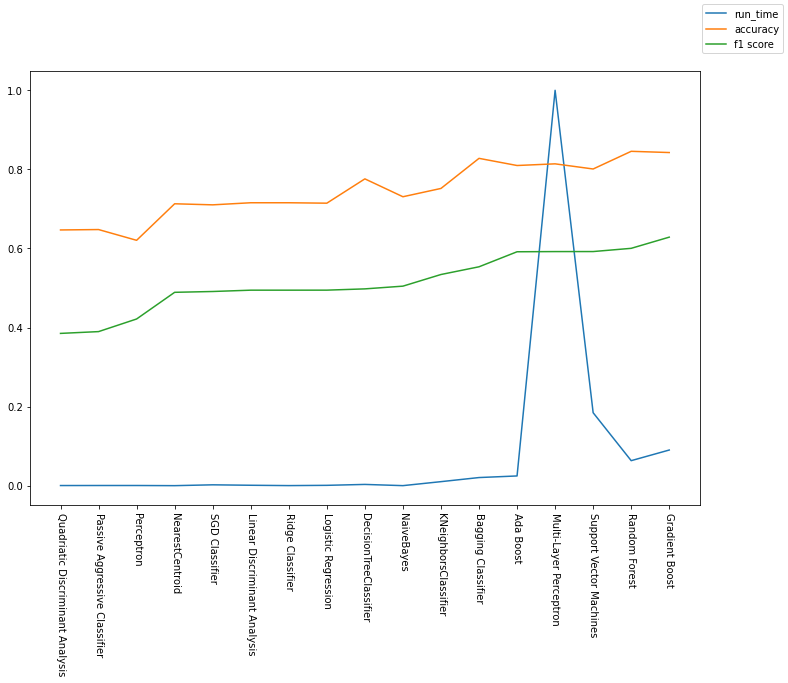

In [20]:
compare_basic_models(run_basic_model_with_smote)

### Hyper Parameter Optimization <a class='anchor' id='hyperparamoptimize'></a>

#### Test GradientBoost with GridSearchCV  <a class='anchor' id='GridSearchGradientBoost'></a>

In [42]:
def grid_search_gradient_boosting(X, y):
    sm = SMOTE(random_state=1)
    gbc = GradientBoostingClassifier(random_state=1)
    p = imblearn.pipeline.Pipeline([('sm', sm), ('gbc', gbc)])
    param_grid = {
        'gbc__n_estimators': [10, 100, 1000],
        #'gbc__loss': ['deviance', 'exponential'],
        'gbc__max_depth': [3, 10],
        'gbc__min_samples_split': [i for i in range(2, 210, 40)],
        'gbc__max_features': [None, 'auto', 'sqrt', 'log2'],
    }
    scorer = make_scorer(metrics.f1_score)
    cv1 = StratifiedKFold(n_splits=6, random_state=10, shuffle=True)
    search = GridSearchCV(p, param_grid, n_jobs=7, cv=cv1, scoring=scorer)
    search.fit(X, y)
    print("GRADIENT BOOSTING")
    print(f"Best Params = {search.best_params_}")
    print(f"Best score = {search.best_score_}")
    print('-' * 120)
    return search.best_estimator_

random.seed(22)
gbc = grid_search_gradient_boosting(scaled_X.to_numpy(), y.to_numpy())

GRADIENT BOOSTING
Best Params = {'gbc__max_depth': 3, 'gbc__max_features': None, 'gbc__min_samples_split': 42, 'gbc__n_estimators': 100}
Best score = 0.6311883955640584
------------------------------------------------------------------------------------------------------------------------


In [176]:
def grid_search_gradient_boosting2(X, y):
    sm = SMOTE(random_state=1)
    gbc = GradientBoostingClassifier(random_state=1)
    p = imblearn.pipeline.Pipeline([('sm', sm), ('gbc', gbc)])
    param_grid = {
        'gbc__n_estimators': [10, 100, 1000, 10000],
        #'gbc__loss': ['deviance', 'exponential'],
        'gbc__max_depth': [3],
        'gbc__min_samples_split': [42],
        'gbc__max_features': [None],
        'gbc__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]
    }
    scorer = make_scorer(metrics.f1_score)
    cv1 = StratifiedKFold(n_splits=6, random_state=10, shuffle=True)
    search = GridSearchCV(p, param_grid, n_jobs=7, cv=cv1, scoring=scorer)
    search.fit(X, y)
    print("GRADIENT BOOSTING")
    print(f"Best Params = {search.best_params_}")
    print(f"Best score = {search.best_score_}")
    print('-' * 120)
    return search.best_estimator_

random.seed(22)
gbc = grid_search_gradient_boosting2(scaled_X.to_numpy(), y.to_numpy())

GRADIENT BOOSTING
Best Params = {'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__max_features': None, 'gbc__min_samples_split': 42, 'gbc__n_estimators': 100}
Best score = 0.6311883955640584
------------------------------------------------------------------------------------------------------------------------


#### Test RandomForest with GridSearchCV <a class='anchor' id='GridSearchRandomForest'></a>

In [36]:
def grid_search_random_forest(X, y):
    sm = SMOTE(random_state=1)
    rfc = RandomForestClassifier(random_state=1)
    p = imblearn.pipeline.Pipeline([('sm', sm), ('rfc', rfc)])
    param_grid = {
        'rfc__n_estimators': [10, 100, 1000],
        'rfc__criterion': ['gini', 'entropy'],
        'rfc__min_samples_split': [i for i in range(20, 200, 40)],
        'rfc__max_depth': [None, 5],
        'rfc__class_weight': ['balanced', 'balanced_subsample']
    }
    #scoring = {'F1': make_scorer(metrics.f1_score), 'ACC': make_scorer(metrics.accuracy_score)}
    scorer = make_scorer(metrics.f1_score)
    cv1 = StratifiedKFold(n_splits=6, random_state=10, shuffle=True)
    search = GridSearchCV(p, param_grid, n_jobs=7, cv=cv1, scoring=scorer)
    search.fit(X, y)
    print("RANDOM FOREST")
    print(f"Best Params = {search.best_params_}")
    print(f"Best score = {search.best_score_}")
    print('-' * 120)
    return search.best_estimator_

random.seed(22)
rfc  = grid_search_random_forest(scaled_X.to_numpy(), y.to_numpy())

RANDOM FOREST
Best Params = {'rfc__class_weight': 'balanced_subsample', 'rfc__criterion': 'entropy', 'rfc__max_depth': None, 'rfc__min_samples_split': 100, 'rfc__n_estimators': 1000}
Best score = 0.624375225286892
------------------------------------------------------------------------------------------------------------------------


In [172]:
def grid_search_random_forest2(X, y):
    sm = SMOTE(random_state=1)
    rfc = RandomForestClassifier(random_state=1)
    p = imblearn.pipeline.Pipeline([('sm', sm), ('rfc', rfc)])
    param_grid = {
        'rfc__n_estimators': [1000, 10000],
        'rfc__criterion': ['entropy'],
        'rfc__min_samples_split': [42],
        'rfc__max_depth': [None, 5],
        'rfc__class_weight': ['balanced_subsample'],
        'rfc__min_impurity_decrease': [0, 0.00001, 0.0001, 0.001, 0.01, 0.1]
    }
    #scoring = {'F1': make_scorer(metrics.f1_score), 'ACC': make_scorer(metrics.accuracy_score)}
    scorer = make_scorer(metrics.f1_score)
    cv1 = StratifiedKFold(n_splits=6, random_state=10, shuffle=True)
    search = GridSearchCV(p, param_grid, n_jobs=7, cv=cv1, scoring=scorer)
    search.fit(X, y)
    print("RANDOM FOREST")
    print(f"Best Params = {search.best_params_}")
    print(f"Best score = {search.best_score_}")
    print('-' * 120)
    return search.best_estimator_

random.seed(22)
rfc  = grid_search_random_forest2(scaled_X.to_numpy(), y.to_numpy())

RANDOM FOREST
Best Params = {'rfc__class_weight': 'balanced_subsample', 'rfc__criterion': 'entropy', 'rfc__max_depth': None, 'rfc__min_impurity_decrease': 0.0001, 'rfc__min_samples_split': 42, 'rfc__n_estimators': 1000}
Best score = 0.6212218073500146
------------------------------------------------------------------------------------------------------------------------


#### Test SVC with GridSearchCV <a class='anchor' id='GridSearchSVC'></a>

In [217]:
def grid_search_svc(X, y):
    sm = SMOTE(random_state=1)
    svc = SVC(random_state=1)
    p = imblearn.pipeline.Pipeline([('sm', sm), ('svc', svc)])
    param_grid = {
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        'svc__class_weight': [None, 'balanced'],
        'svc__gamma': ['scale', 'auto', 0.001],
        'sm__k_neighbors': [5, 20],
    }
    scorer = make_scorer(metrics.f1_score)
    cv1 = StratifiedKFold(n_splits=6, random_state=10, shuffle=True)
    search = GridSearchCV(p, param_grid, n_jobs=7, cv=cv1, scoring=scorer)
    search.fit(X, y)
    print("SVC")
    print(f"Best Params = {search.best_params_}")
    print(f"Best score = {search.best_score_}")
    print('-' * 120)
    return search.best_estimator_

random.seed(22)
selector = []
svc = grid_search_svc(scaled_X.to_numpy(), y.to_numpy())

SVC
Best Params = {'sm__k_neighbors': 20, 'svc__class_weight': None, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Best score = 0.5958117676964181
------------------------------------------------------------------------------------------------------------------------


In [218]:
scaled_X.shape

(10000, 13)

#### Test MLP with GridSearchCV <a class='anchor' id='GridSearchMLP'></a>

In [48]:
def grid_search_mlp(X, y):
    sm = SMOTE(random_state=1)
    mlp = MLPClassifier(random_state=1, n_iter_no_change=100, max_iter=10000)
    p = imblearn.pipeline.Pipeline([('sm', sm), ('mlp', mlp)])
    param_grid = {
        'mlp__hidden_layer_sizes': [(100,), (100, 50,),],
        'mlp__activation': ['relu', 'logistic'],
        'mlp__solver': ['adam'],
        'mlp__learning_rate': ['constant', 'adaptive'],
        #'mlp__alpha': [0.1, 0.01, 0.001, 0.0001]
    }
    scorer = make_scorer(metrics.f1_score)
    cv1 = StratifiedKFold(n_splits=6, random_state=10, shuffle=True)
    search = GridSearchCV(p, param_grid, n_jobs=7, cv=cv1, scoring=scorer)
    search.fit(X, y)
    print("MULTI LEVEL PERCEPTRON")
    print(f"Best Params = {search.best_params_}")
    print(f"Best score = {search.best_score_}")
    print('-' * 120)
    return search.best_estimator_

random.seed(22)
mlp = grid_search_mlp(scaled_X.to_numpy(), y.to_numpy())

MULTI LEVEL PERCEPTRON
Best Params = {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'}
Best score = 0.5404128313643786
------------------------------------------------------------------------------------------------------------------------


#### Final Baseline <a class='anchor' id='FinalBaseline'></a>

*GRADIENT BOOSTING*
Best Params = {'gbc__max_depth': 3, 'gbc__max_features': None, 'gbc__min_samples_split': 42, 'gbc__n_estimators': 100}
Best score = 0.6311883955640584

*RANDOM FOREST*
Best Params = {'rfc__class_weight': 'balanced_subsample', 'rfc__criterion': 'entropy', 'rfc__max_depth': None, 'rfc__min_samples_split': 100, 'rfc__n_estimators': 1000}
Best score = 0.624375225286892

*SVC*
Best Params = {'sm__k_neighbors': 20, 'svc__class_weight': None, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Best score = 0.5958117676964181

*MULTI LEVEL PERCEPTRON*
Best Params = {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'}
Best score = 0.5404128313643786



### Basic Experimentation <a class='anchor' id='BasicExperimentation'></a>

#### Are there any outliers detected by Random Forest? <a class='anchor' id='RandomForestBasicCount'></a>

In [213]:
tdf = read_file()
tdf = engineer_features2(tdf)
clf = IsolationForest(contamination=1.0e-2000).fit(StandardScaler().fit_transform(tdf))
outliers = clf.predict(tdf)
out = 0
inl = 0
for i in outliers:
    if 1 == i:
        inl += 1
    else:
        out += 1
print(f"Outliers = {out} in = {inl}")

Outliers = 20 in = 9980


In [245]:
# Check the number of items categorized as outliers as the random number is varied
for r in range(10):
    tdf = read_file()
    tdf = engineer_features2(tdf)
    clf = IsolationForest(contamination=0.01, random_state=r, n_estimators=1000, n_jobs=-1).fit(StandardScaler().fit_transform(tdf))
    outliers = clf.predict(tdf)
    tdf = tdf[outliers == 1]
    print(r, tdf.shape)

print('-' * 80)
for r in range(10):
    tdf = read_file()
    tdf = engineer_features2(tdf)
    clf = IsolationForest(contamination=0.001, random_state=r, n_estimators=1000, n_jobs=-1).fit(StandardScaler().fit_transform(tdf))
    outliers = clf.predict(tdf)
    tdf = tdf[outliers == 1]
    print(r, tdf.shape)

0 (155, 14)
1 (231, 14)
2 (386, 14)
3 (540, 14)
4 (323, 14)
5 (435, 14)
6 (147, 14)
7 (166, 14)
8 (320, 14)
9 (272, 14)
--------------------------------------------------------------------------------
0 (1658, 14)
1 (3905, 14)
2 (4221, 14)
3 (3715, 14)
4 (2616, 14)
5 (2760, 14)
6 (2492, 14)
7 (2296, 14)
8 (2865, 14)
9 (2856, 14)


We'll not use isolation forest because it is very sensitive to the random state, and with the same contamination it produces a vastly different output depending on the random value

In [272]:
def perform_grid_search(X, y, params, param_grid, description):
    p = imblearn.pipeline.Pipeline(params)
    cv1 = StratifiedKFold(n_splits=6, random_state=10, shuffle=True)
    scorer = make_scorer(metrics.f1_score)
    search = GridSearchCV(p, param_grid, n_jobs=7, cv=cv1, scoring=scorer)
    search.fit(X, y)
    print(description)
    print(f"Best Params = {search.best_params_}")
    print(f"Best score = {search.best_score_}")
    print('-' * 120)
    return search.best_estimator_   

#### Feature Selection, PCA, SVC <a class='anchor' id='SVC_FS_PCA'></a>

In [288]:
def grid_search_svc_1(X, y):
    sm = SMOTE(random_state=1)
    svc = SVC(random_state=1)
    ms = MinMaxScaler()
    pca = PCA(random_state=0)
    rfecv = RFECV(estimator=RandomForestClassifier())
    params = [('sm', sm), ('pca', pca), ('rfe', rfecv), ('svc', svc)]
    param_grid = {
        'svc__kernel': ['rbf'],
        'svc__class_weight': [None],
        'svc__gamma': ['auto'],
        'sm__k_neighbors': [20],
        'pca__n_components': range(6, X.shape[1]+1)
    }
    return perform_grid_search(X, y, params, param_grid, description="PCA, RFECV, SVC")

random.seed(22)
selector = []
svc = grid_search_svc_1(scaled_X.to_numpy(), y.to_numpy())

PCA, RFECV, SVC
Best Params = {'pca__n_components': 10, 'sm__k_neighbors': 20, 'svc__class_weight': None, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Best score = 0.5963218633254905
------------------------------------------------------------------------------------------------------------------------


In [289]:
print(svc.named_steps['rfe'].support_)
for i, j in zip(svc.named_steps['rfe'].support_, scaled_X.columns):
    print(j, i)

[ True  True  True  True  True  True  True  True  True  True]
CreditScore True
Age True
Tenure True
Balance True
NumOfProducts True
HasCrCard True
IsActiveMember True
EstimatedSalary True
Gender_Female True
Gender_Male True


Select the best parameters from above, and run them again, this time without feature selection

In [283]:
def grid_search_svc_1(X, y):
    sm = SMOTE(random_state=1)
    svc = SVC(random_state=1)
    ms = MinMaxScaler()
    pca = PCA(random_state=0)
    rfecv = RFECV(estimator=RandomForestClassifier())
    params = [('sm', sm), ('pca', pca), ('svc', svc)]
    param_grid = {
        'svc__kernel': ['rbf'],
        'svc__class_weight': [None],
        'svc__gamma': ['auto'],
        'sm__k_neighbors': [20],
        'pca__n_components': range(10, X.shape[1]+1)
    }
    return perform_grid_search(X, y, params, param_grid, description="PCA, SVC")

random.seed(22)
selector = []
svc = grid_search_svc_1(scaled_X.to_numpy(), y.to_numpy())

PCA, RFECV, SVC
Best Params = {'pca__n_components': 10, 'sm__k_neighbors': 20, 'svc__class_weight': None, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Best score = 0.5963218633254905
------------------------------------------------------------------------------------------------------------------------


Do the same steps again, except use an SVC classifier for feature selection

In [286]:
def grid_search_svc_1(X, y):
    sm = SMOTE(random_state=1)
    svc = SVC(random_state=1)
    ms = MinMaxScaler()
    pca = PCA(random_state=0)
    rfecv = RFECV(estimator=DecisionTreeClassifier())
    params = [('sm', sm), ('pca', pca), ('rfe', rfecv), ('svc', svc)]
    param_grid = {
        'svc__kernel': ['rbf'],
        'svc__class_weight': [None],
        'svc__gamma': ['auto'],
        'sm__k_neighbors': [20],
        'pca__n_components': range(10, X.shape[1]+1)
    }
    return perform_grid_search(X, y, params, param_grid, description="PCA, RFECV, SVC")

random.seed(22)
selector = []
svc = grid_search_svc_1(scaled_X.to_numpy(), y.to_numpy())

PCA, RFECV, SVC
Best Params = {'pca__n_components': 13, 'sm__k_neighbors': 20, 'svc__class_weight': None, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Best score = 0.5967162189237114
------------------------------------------------------------------------------------------------------------------------


In [287]:
print(svc.named_steps['rfe'].support_)
for i, j in zip(svc.named_steps['rfe'].support_, scaled_X.columns):
    print(j, i)

[ True  True  True  True  True  True  True  True  True  True  True False
 False]
CreditScore True
Age True
Tenure True
Balance True
NumOfProducts True
HasCrCard True
IsActiveMember True
EstimatedSalary True
Gender_Female True
Gender_Male True
Geography_France True
Geography_Germany False
Geography_Spain False


#### Feature Selection, Random Forest  <a class='anchor' id='RF_FS'></a>

In [281]:
def grid_search_random_forest_fs(X, y):
    sm = SMOTE(random_state=1)
    rf = RandomForestClassifier(random_state=1, criterion='entropy', n_estimators=1000, class_weight='balanced_subsample')
    rfecv = RFECV(estimator=RandomForestClassifier())
    param_grid = {'rf__min_samples_split': [100, 150]}
    params = [('sm', sm), ('rf', rf)]
    return perform_grid_search(X, y, params, param_grid, description="Random Forest Classifier with Feature Selection")

random.seed(22)
rfcfs = grid_search_random_forest_fs(scaled_X.to_numpy(), y.to_numpy())

Random Forest Classifier with Feature Selection
Best Params = {'rf__min_samples_split': 100}
Best score = 0.624375225286892
------------------------------------------------------------------------------------------------------------------------


In [277]:
def grid_search_random_forest_fs(X, y):
    sm = SMOTE(random_state=1)
    rf = RandomForestClassifier(random_state=1, criterion='entropy', n_estimators=1000, class_weight='balanced_subsample')
    rfecv = RFECV(estimator=RandomForestClassifier())
    param_grid = {'rf__min_samples_split': [100, 150]}
    params = [('sm', sm), ('rfecv', rfecv), ('rf', rf)]
    return perform_grid_search(X, y, params, param_grid, description="Random Forest Classifier with Feature Selection")

random.seed(22)
rfcfs = grid_search_random_forest_fs(scaled_X.to_numpy(), y.to_numpy())

Random Forest Classifier with Feature Selection
Best Params = {'rf__min_samples_split': 100}
Best score = 0.6255208031561018
------------------------------------------------------------------------------------------------------------------------


In [280]:
print(svc.named_steps['rfe'].support_)
for i, j in zip(rfcfs.named_steps['rfecv'].support_, scaled_X.columns):
    print(j, i)

[ True  True  True  True  True  True  True  True  True  True]
CreditScore True
Age True
Tenure True
Balance True
NumOfProducts True
HasCrCard True
IsActiveMember True
EstimatedSalary True
Gender_Female True
Gender_Male True
Geography_France True
Geography_Germany True
Geography_Spain False
Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Gender_Female', 'Gender_Male',
       'Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype='object')


#### Compare Feature Selection Methods <a class='anchor' id='CMP_FS'></a>

In [164]:
def feature_select_score(X, y, selector, model_gen_fn, model_desc, selector_desc,\
                         min_max_scale=False, do_pca=False, n_pca=-1):
    p = []
    if min_max_scale:
        p.append(('ms', MinMaxScaler(),))
    p.append(('sm', SMOTE(),))
    if None != selector:
        p.append(('sel', selector(),))
    if do_pca:
        if -1 == n_pca:
            n_pca = 10
        p.append(('pca', PCA(n_components=n_pca),))
    p.append(('model', model_gen_fn(),))
    print(p)
    p = imblearn.pipeline.Pipeline(p)
    y_pred = cross_val_predict(p, X, y, \
                           cv=model_selection.StratifiedKFold(n_splits=6, shuffle=True, random_state=2),\
                           n_jobs=7)
    print(f"Selector: {selector_desc} Model: {model_desc}\n{metrics.classification_report(y, y_pred)}")
    return metrics.accuracy_score(y, y_pred), metrics.f1_score(y, y_pred),\
            metrics.classification_report(y, y_pred), metrics.confusion_matrix(y, y_pred)

best_models_ = [
    ('GradientBoosting', lambda: GradientBoostingClassifier(random_state=0, max_depth=3, min_samples_split=42, n_estimators=100)),
    ('RandomForest', lambda: RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', max_depth=None, min_samples_split=100, n_estimators=1000, random_state=0)),
    ('SVC', lambda: SVC(class_weight=None, gamma='auto', kernel='rbf', random_state=0)),
]


all_feature_selectors_ = [
    ('LinearSVC', lambda: SelectFromModel(LinearSVC())),
    ('LinearSVC L1', lambda: SelectFromModel(LinearSVC(penalty="l1"))),
    ('Variance Threshold 0.8', lambda: VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('RFECV RandomForest', lambda: RFECV(estimator=RandomForestClassifier())),
    ('FWE chi2', lambda: SelectFwe(chi2, alpha=0.01)),
    ('FWE f_classif', lambda: SelectFwe(f_classif, alpha=0.01)),
    ('Tree Based Feature Selection', lambda: SelectFromModel(ExtraTreesClassifier(n_estimators=50))),
    ('NONE', None),
]

def compare_selectors_with_models(models, selectors,\
                                 min_max_scale=False, do_pca=False, n_pca=-1):
    """
    For each combination of model and feature selector, run cross validation and aggregate
    the accuracy and f1 scores
    """
    all_models = {}
    desc_string = ""
    for model_desc, model_gen in models:
        accuracy_scores = []
        f1_scores = []
        selector_descs = []
        for selector_desc, selector in selectors:
            acc = 0
            f1 = 0
            try:
                acc, f1, report, conf_mat = feature_select_score(scaled_X.to_numpy(), y.to_numpy(),\
                                               selector, model_gen, model_desc, selector_desc,\
                                                min_max_scale, do_pca, n_pca)
                accuracy_scores.append(acc)
                f1_scores.append(f1)
            except:
                print(f'====>>>> Failure in {model_desc}, {selector_desc}')
                accuracy_scores.append(acc)
                f1_scores.append(f1)
            selector_descs.append(selector_desc)
        sorted_indices = np.argsort(f1_scores)
        desc_string += "\nMODEL: %s\n---------------------\n" % model_desc
        for i in sorted_indices:
            desc_string += ("%40s %10.5f %10.5f\n" % (selector_descs[i], accuracy_scores[i], f1_scores[i]))
        desc_string += '-------------------------------------------------------------------------------\n'
        print(desc_string)
        all_models[desc_string] = {'accuracy': accuracy_scores, 'f1': f1_scores, 'selectors': selector_descs}
    return all_models, desc_string



In [124]:
all_models, desc_string = compare_selectors_with_models(best_models_, all_feature_selectors_)

Selector: LinearSVC Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      7963
           1       0.50      0.56      0.53      2037

    accuracy                           0.80     10000
   macro avg       0.69      0.71      0.70     10000
weighted avg       0.81      0.80      0.80     10000

====>>>> Failure in GradientBoosting, LinearSVC L1
Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7963
           1       0.61      0.65      0.63      2037

    accuracy                           0.84     10000
   macro avg       0.76      0.77      0.76     10000
weighted avg       0.85      0.84      0.84     10000

Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7963
           1       0.61      0.6

Selector: NONE Model: SVC
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      7963
           1       0.50      0.72      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg       0.83      0.80      0.81     10000


MODEL: GradientBoosting
---------------------
                            LinearSVC L1    0.00000    0.00000
                                FWE chi2    0.00000    0.00000
                               LinearSVC    0.79660    0.52938
            Tree Based Feature Selection    0.83160    0.59636
                           FWE f_classif    0.83210    0.62396
                                    NONE    0.84340    0.62750
                  Variance Threshold 0.8    0.84270    0.62822
                      RFECV RandomForest    0.84300    0.62831
-------------------------------------------------------------------------------

MODEL: RandomFo

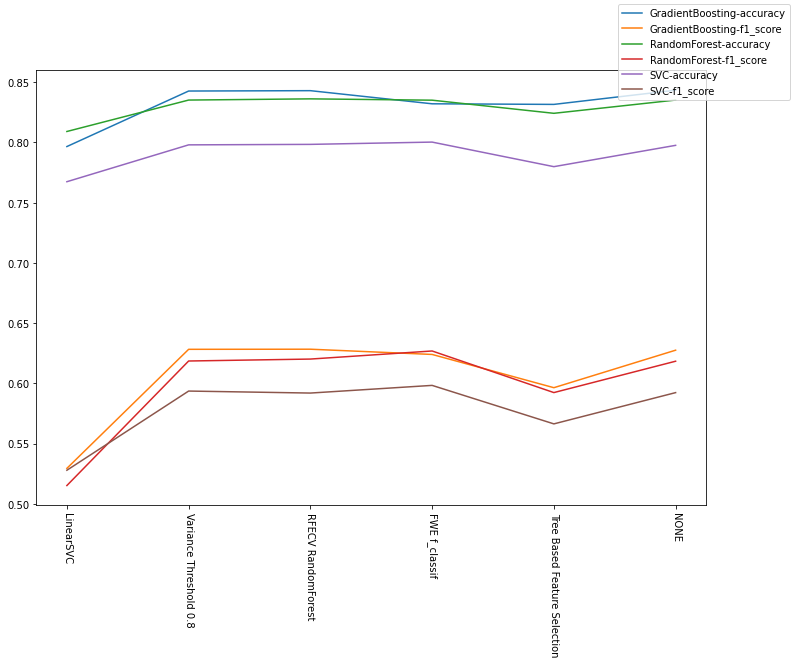

In [161]:
def plot_graph_1(all_models):
    """
    Plot the accuracy and F1 scores from the data output by the previous step
    """
    am = ['GradientBoosting', 'RandomForest', 'SVC']

    i = 0
    accuracy_scores = None
    f1_scores = None
    selector_descs = None
    fig, ax = plt.subplots()

    for key, val in all_models.items():
        model = am[i]
        i+=1
        accuracy_scores = val['accuracy']
        f1_scores = val['f1']
        selector_descs = val['selectors']
        new_f1 = []
        new_acc = []
        new_descs = []
        for acc, f1, d in zip(accuracy_scores, f1_scores, selector_descs):
            if 0 != f1:
                new_f1.append(f1)
                new_acc.append(acc)
                new_descs.append(d)
        accuracy_scores = new_acc
        f1_scores = new_f1
        selector_descs = new_descs
        ax.plot(accuracy_scores, label="%s-accuracy" % model)
        ax.plot(f1_scores, label="%s-f1_score" % model)
    plt.xticks(np.arange(0, len(f1_scores), 1.0))
    ax.set_xticklabels(selector_descs, rotation=270)
    fig.legend()
    
plot_graph_1(all_models)

In [126]:
print("Best models with Feature Selection")
print(desc_string)

Best models with Feature Selection

MODEL: GradientBoosting
---------------------
                            LinearSVC L1    0.00000    0.00000
                                FWE chi2    0.00000    0.00000
                               LinearSVC    0.79660    0.52938
            Tree Based Feature Selection    0.83160    0.59636
                           FWE f_classif    0.83210    0.62396
                                    NONE    0.84340    0.62750
                  Variance Threshold 0.8    0.84270    0.62822
                      RFECV RandomForest    0.84300    0.62831
-------------------------------------------------------------------------------

MODEL: RandomForest
---------------------
                            LinearSVC L1    0.00000    0.00000
                                FWE chi2    0.00000    0.00000
                               LinearSVC    0.80910    0.51511
            Tree Based Feature Selection    0.82420    0.59230
                                    NON

The best feature selectors are:
1. FWE f_classif
2. NONE
3. RFECV Random Forest
4. Variance Threshold 0.8

However the difference is not much

In [135]:
best_selectors_ = [
    ('Variance Threshold 0.8', lambda: VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('RFECV RandomForest', lambda: RFECV(estimator=RandomForestClassifier())),
    ('FWE f_classif', lambda: SelectFwe(f_classif, alpha=0.01)),
    ('NONE', None),
]

#### Check if MinMaxScaling makes a difference <a class='anchor' id='BEMMS'></a>

##### See if MinMax Scaling makes a difference. Standardization has already been performed earlier with unit SD

In [158]:
all_models_mms, desc_string_mms = compare_selectors_with_models(best_models_, best_feature_selectors_,\
                                                        min_max_scale=True, do_pca=False, n_pca=-1)

[('ms', MinMaxScaler()), ('sm', SMOTE()), ('sel', VarianceThreshold(threshold=0.15999999999999998)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.86      0.69      0.77      7963
           1       0.32      0.57      0.41      2037

    accuracy                           0.66     10000
   macro avg       0.59      0.63      0.59     10000
weighted avg       0.75      0.66      0.69     10000

[('ms', MinMaxScaler()), ('sm', SMOTE()), ('sel', RFECV(estimator=RandomForestClassifier())), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      7963
           1       0.58      0.67      0.62      2037

    accuracy                           0.83     10


MODEL: GradientBoosting
---------------------
                  Variance Threshold 0.8    0.84200    0.62147
                           FWE f_classif    0.83520    0.62323
                      RFECV RandomForest    0.84230    0.62372
                                    NONE    0.84360    0.62726
-------------------------------------------------------------------------------

MODEL: RandomForest
---------------------
                  Variance Threshold 0.8    0.83390    0.61363
                                    NONE    0.83510    0.61624
                      RFECV RandomForest    0.83610    0.61893
                           FWE f_classif    0.83390    0.62514
-------------------------------------------------------------------------------

MODEL: SVC
---------------------
                  Variance Threshold 0.8    0.79730    0.59158
                      RFECV RandomForest    0.79850    0.59432
                                    NONE    0.79980    0.59490
                       

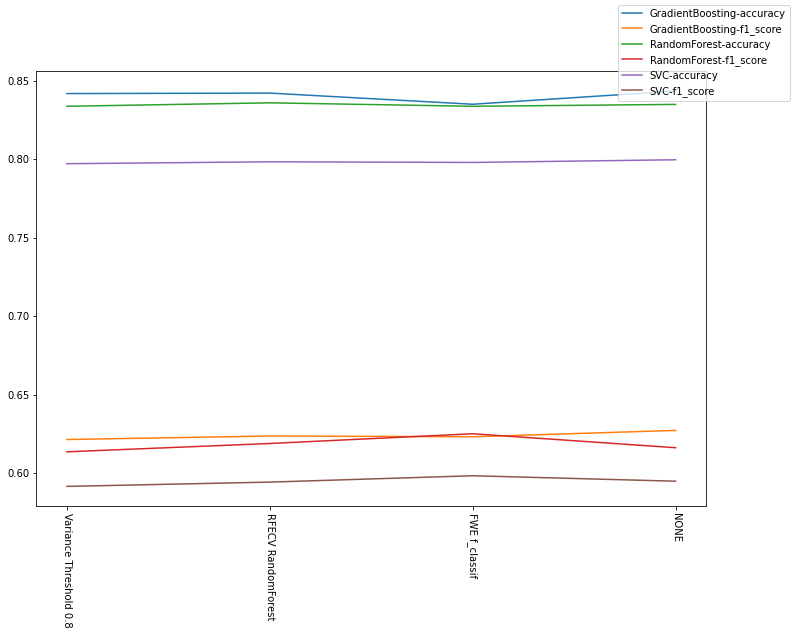

In [162]:
plot_graph_1(all_models_mms)
print(desc_string_mms)

#### Add PCA to the mix <a class='anchor' id='BEPCA'></a>

In [167]:
all_models_mmspca_a = []
desc_strings_mmspca_a = []
ncap_a = []
for npca in range(5, 15):
    print('=' * 120)
    print(f'PCA {npca}')
    print('-' * 80)
    all_models_mmspca, desc_string_mmspca = compare_selectors_with_models(best_models_, best_feature_selectors_,\
                                                            min_max_scale=False, do_pca=True, n_pca=10)
    all_models_mmspca_a.append(all_models_mmspca)
    desc_strings_mmspca_a.append(desc_string_mmspca)
    ncap_a.append(npca)

PCA 5
--------------------------------------------------------------------------------
[('sm', SMOTE()), ('sel', VarianceThreshold(threshold=0.15999999999999998)), ('pca', PCA(n_components=10)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7963
           1       0.49      0.72      0.59      2037

    accuracy                           0.79     10000
   macro avg       0.71      0.77      0.72     10000
weighted avg       0.83      0.79      0.81     10000

[('sm', SMOTE()), ('sel', RFECV(estimator=RandomForestClassifier())), ('pca', PCA(n_components=10)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      7963
    

Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7963
           1       0.49      0.72      0.59      2037

    accuracy                           0.79     10000
   macro avg       0.71      0.77      0.72     10000
weighted avg       0.83      0.79      0.81     10000

[('sm', SMOTE()), ('sel', RFECV(estimator=RandomForestClassifier())), ('pca', PCA(n_components=10)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7963
           1       0.49      0.72      0.58      2037

    accuracy                           0.79     10000
   macro avg       0.70      0.76      0.72     10000
weighted avg       0.83      0.79      0.80     10000

[('sm', SMOTE()), ('sel', SelectFwe(alpha=0.01)), ('pca', 

Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7963
           1       0.49      0.73      0.59      2037

    accuracy                           0.79     10000
   macro avg       0.71      0.77      0.72     10000
weighted avg       0.83      0.79      0.81     10000

[('sm', SMOTE()), ('sel', RFECV(estimator=RandomForestClassifier())), ('pca', PCA(n_components=10)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      7963
           1       0.51      0.70      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.76      0.73     10000
weighted avg       0.83      0.80      0.81     10000

[('sm', SMOTE()), ('sel', SelectFwe(alpha=0.01)), ('pca', 

Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.82      0.86      7963
           1       0.50      0.73      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg       0.84      0.80      0.81     10000

[('sm', SMOTE()), ('sel', RFECV(estimator=RandomForestClassifier())), ('pca', PCA(n_components=10)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      7963
           1       0.50      0.70      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.76      0.73     10000
weighted avg       0.83      0.80      0.81     10000

[('sm', SMOTE()), ('sel', SelectFwe(alpha=0.01)), ('pca', 

Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7963
           1       0.50      0.73      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg       0.84      0.80      0.81     10000

[('sm', SMOTE()), ('sel', RFECV(estimator=RandomForestClassifier())), ('pca', PCA(n_components=10)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7963
           1       0.49      0.71      0.58      2037

    accuracy                           0.79     10000
   macro avg       0.70      0.76      0.72     10000
weighted avg       0.83      0.79      0.80     10000

[('sm', SMOTE()), ('sel', SelectFwe(alpha=0.01)), ('pca', 

Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.82      0.86      7963
           1       0.50      0.72      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg       0.83      0.80      0.81     10000

[('sm', SMOTE()), ('sel', RFECV(estimator=RandomForestClassifier())), ('pca', PCA(n_components=10)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      7963
           1       0.51      0.70      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.76      0.73     10000
weighted avg       0.83      0.80      0.81     10000

[('sm', SMOTE()), ('sel', SelectFwe(alpha=0.01)), ('pca', 

Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7963
           1       0.50      0.72      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg       0.83      0.80      0.81     10000

[('sm', SMOTE()), ('sel', RFECV(estimator=RandomForestClassifier())), ('pca', PCA(n_components=10)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      7963
           1       0.51      0.71      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg       0.83      0.80      0.81     10000

[('sm', SMOTE()), ('sel', SelectFwe(alpha=0.01)), ('pca', 

Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7963
           1       0.50      0.73      0.59      2037

    accuracy                           0.79     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg       0.83      0.79      0.81     10000

[('sm', SMOTE()), ('sel', RFECV(estimator=RandomForestClassifier())), ('pca', PCA(n_components=10)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      7963
           1       0.51      0.71      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg       0.83      0.80      0.81     10000

[('sm', SMOTE()), ('sel', SelectFwe(alpha=0.01)), ('pca', 

Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7963
           1       0.49      0.72      0.59      2037

    accuracy                           0.79     10000
   macro avg       0.71      0.77      0.72     10000
weighted avg       0.83      0.79      0.81     10000

[('sm', SMOTE()), ('sel', RFECV(estimator=RandomForestClassifier())), ('pca', PCA(n_components=10)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7963
           1       0.49      0.72      0.59      2037

    accuracy                           0.79     10000
   macro avg       0.71      0.77      0.72     10000
weighted avg       0.83      0.79      0.81     10000

[('sm', SMOTE()), ('sel', SelectFwe(alpha=0.01)), ('pca', 

Selector: Variance Threshold 0.8 Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7963
           1       0.50      0.73      0.59      2037

    accuracy                           0.79     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg       0.83      0.79      0.81     10000

[('sm', SMOTE()), ('sel', RFECV(estimator=RandomForestClassifier())), ('pca', PCA(n_components=10)), ('model', GradientBoostingClassifier(min_samples_split=42, random_state=0))]
Selector: RFECV RandomForest Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.92      0.82      0.86      7963
           1       0.50      0.71      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.76      0.73     10000
weighted avg       0.83      0.80      0.81     10000

[('sm', SMOTE()), ('sel', SelectFwe(alpha=0.01)), ('pca', 

In [168]:
npca_a = ncap_a

PCA 5
------------------------------------------------------------------------------------------------------------------------

MODEL: GradientBoosting
---------------------
                           FWE f_classif    0.00000    0.00000
                                    NONE    0.78990    0.58552
                  Variance Threshold 0.8    0.79250    0.58690
                      RFECV RandomForest    0.80290    0.59285
-------------------------------------------------------------------------------

MODEL: RandomForest
---------------------
                           FWE f_classif    0.00000    0.00000
                  Variance Threshold 0.8    0.80930    0.59537
                      RFECV RandomForest    0.81420    0.60214
                                    NONE    0.81330    0.60604
-------------------------------------------------------------------------------

MODEL: SVC
---------------------
                           FWE f_classif    0.00000    0.00000
                      


PCA 14
------------------------------------------------------------------------------------------------------------------------

MODEL: GradientBoosting
---------------------
                                    NONE    0.79010    0.58328
                      RFECV RandomForest    0.79540    0.58650
                  Variance Threshold 0.8    0.79430    0.58967
                           FWE f_classif    0.79940    0.59686
-------------------------------------------------------------------------------

MODEL: RandomForest
---------------------
                           FWE f_classif    0.00000    0.00000
                      RFECV RandomForest    0.81150    0.59902
                                    NONE    0.80950    0.60038
                  Variance Threshold 0.8    0.81070    0.60156
-------------------------------------------------------------------------------

MODEL: SVC
---------------------
                           FWE f_classif    0.00000    0.00000
                    

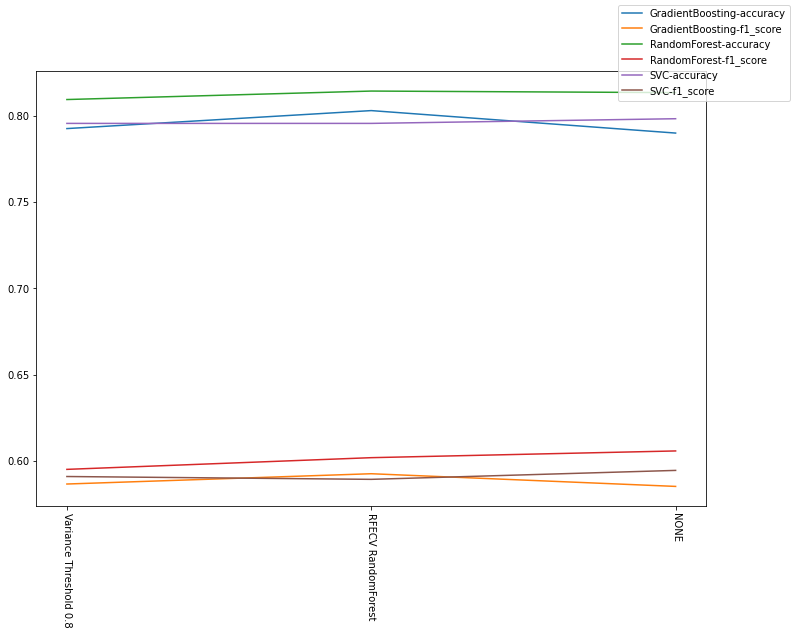

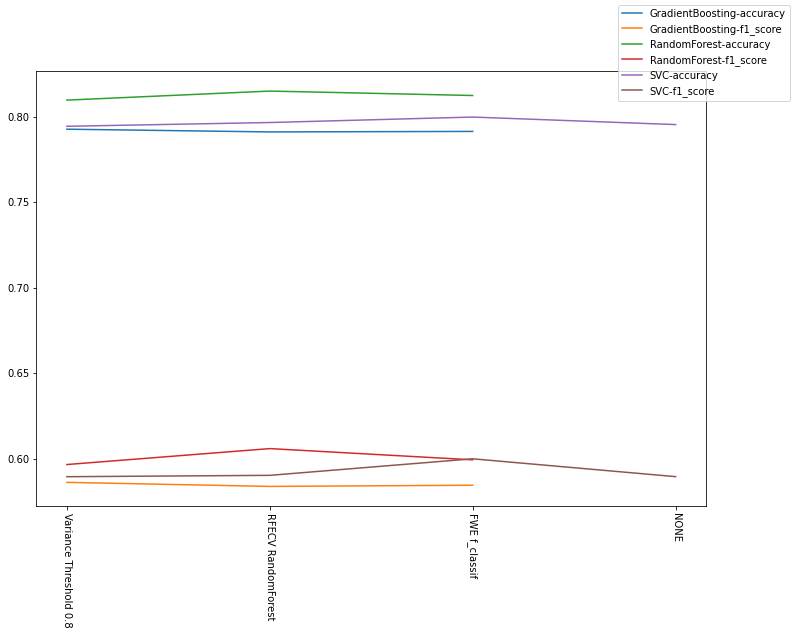

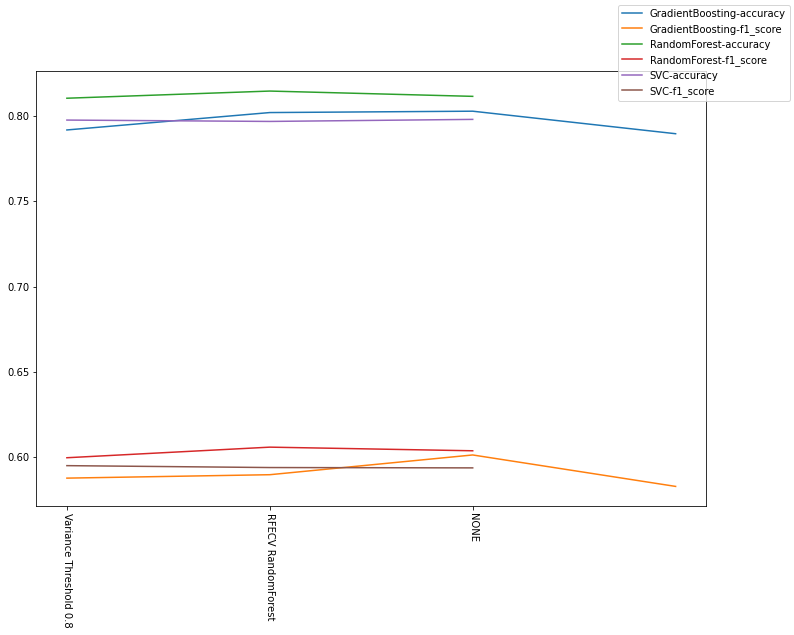

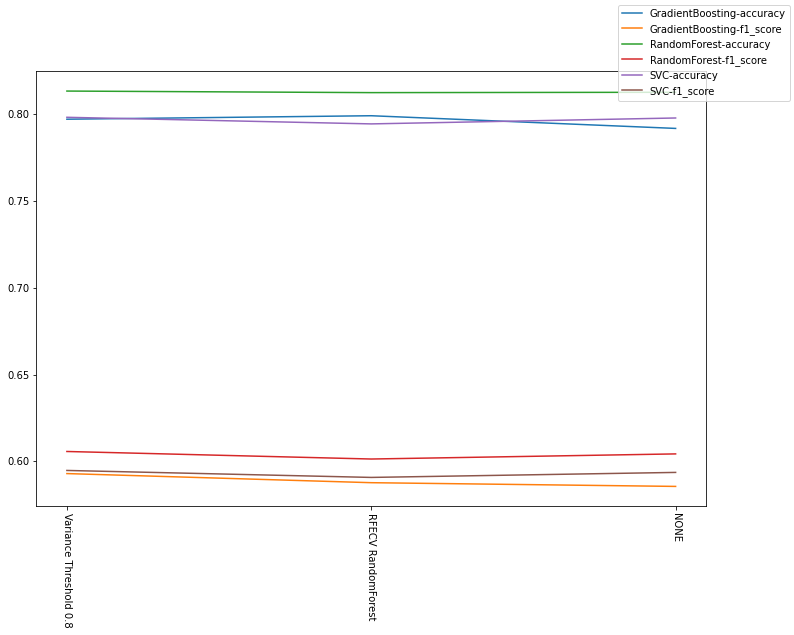

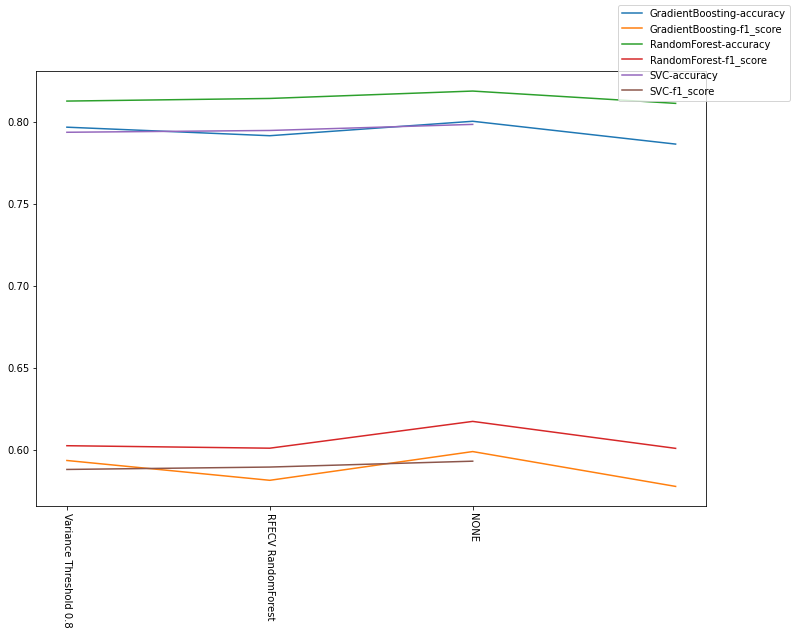

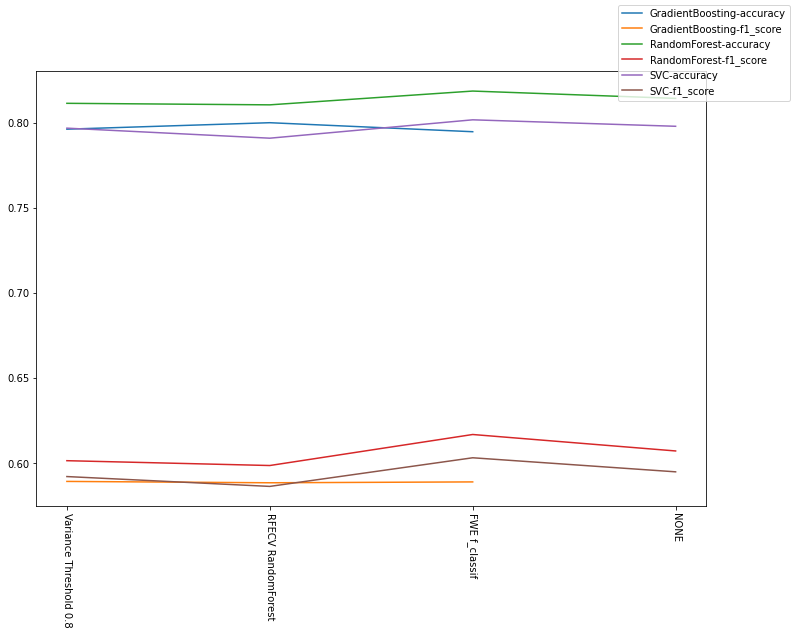

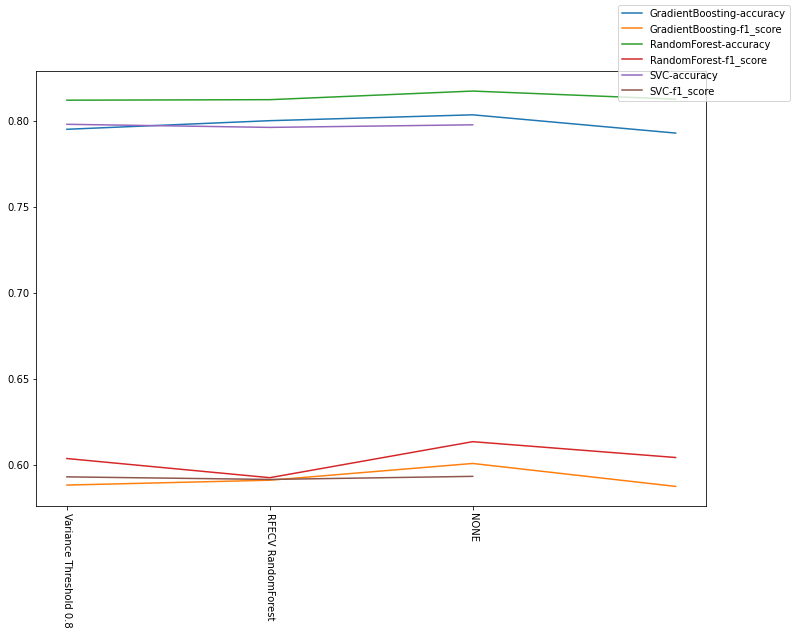

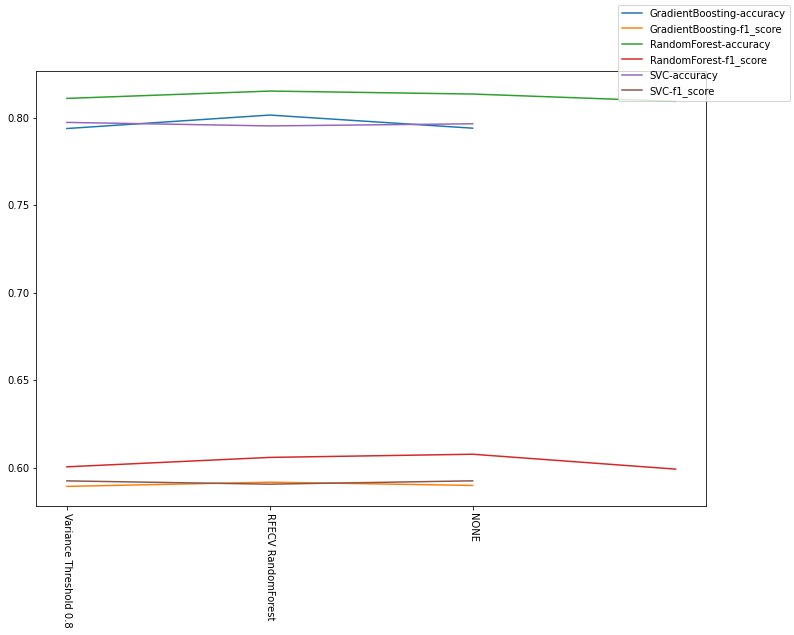

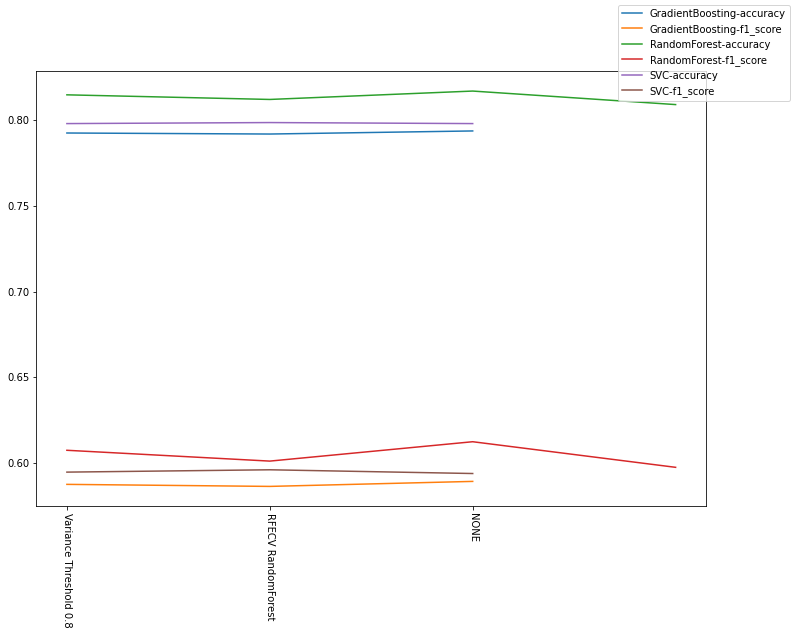

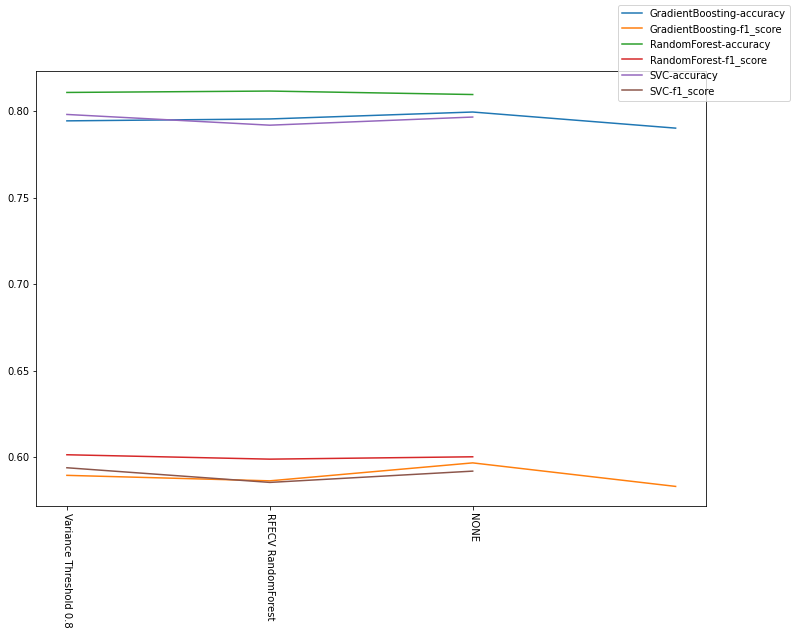

In [169]:
for i, d, m in zip(ncap_a, desc_strings_mmspca_a, all_models_mmspca_a):
    print(f'PCA {i}')
    print('-' * 120)
    print(d)
    plot_graph_1(m)

## Research <a class='anchor' id='ResearchSection'></a>

#### Experiment with weighted features in Random Forest <a class='anchor' id='RFCWeightedFeatures'></a>

RandomForest Basic <function <lambda> at 0x000001EC43C1E5E0>
RandomForest Balanced <function <lambda> at 0x000001EC43C1E550>
Random Forest Balanced Subsample <function <lambda> at 0x000001EC43FA2D30>
Random Forest Weighted 0.8 <function <lambda> at 0x000001EC43FA23A0>
Random Forest Weighted 0.6 <function <lambda> at 0x000001EC43FA2550>
Random Forest Weighted 0.9 <function <lambda> at 0x000001EC43FA2700>
Random Forest 0.7963 <function <lambda> at 0x000001EC43FA28B0>
Random Forest 0.7963 (rev) <function <lambda> at 0x000001EC43FA2A60>

[0.8603999488217603, 0.8609005089738355, 0.8579003286977658, 0.8620002890178267, 0.8613003689778251, 0.8592000087377483, 0.8617004690298435, 0.8587007688498315]

[0.5742653346426003, 0.5697548162058486, 0.5577101012466912, 0.5870480432152809, 0.578779895715622, 0.5782437561433658, 0.5852288885179198, 0.5614763698942369]

------------------------------------------------------------------------------------------------------------------------
                

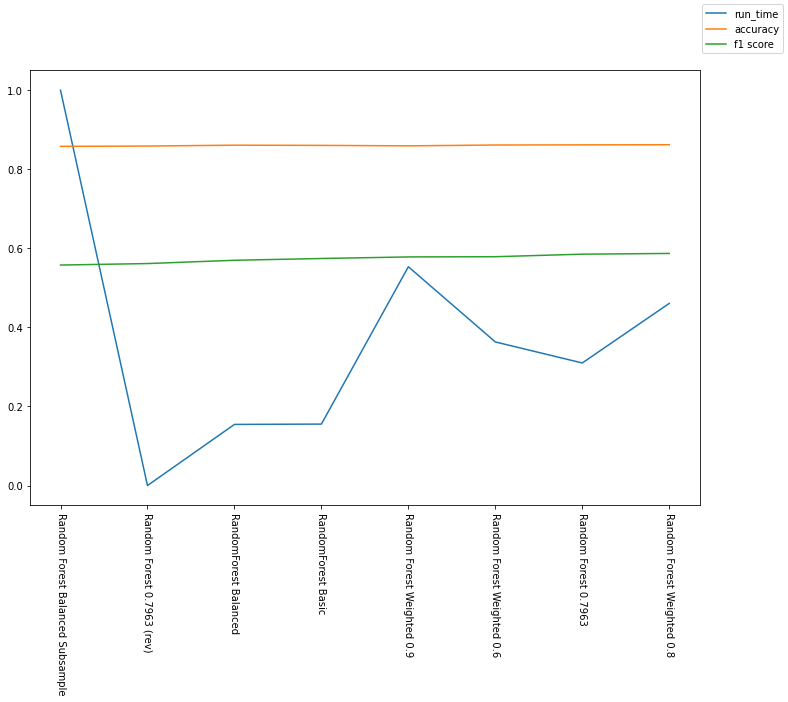

In [182]:
# First check with default parameters, with just this parameter changed
basic_models = [
    ('RandomForest Basic', lambda: RandomForestClassifier(random_state=1)),
    ('RandomForest Balanced', lambda: RandomForestClassifier(random_state=1, class_weight='balanced')),
    ('Random Forest Balanced Subsample', lambda: RandomForestClassifier(random_state=1, class_weight='balanced_subsample')),
    ('Random Forest Weighted 0.8', lambda: RandomForestClassifier(random_state=1, class_weight={1: 0.2, 0: 0.8})),
    ('Random Forest Weighted 0.6', lambda: RandomForestClassifier(random_state=1, class_weight={1: 0.4, 0: 0.6})),
    ('Random Forest Weighted 0.9', lambda: RandomForestClassifier(random_state=1, class_weight={1: 0.1, 0: 0.9})),
    ('Random Forest 0.7963', lambda: RandomForestClassifier(random_state=1, class_weight={1: 2037, 0: 7963})),
    ('Random Forest 0.7963 (rev)', lambda: RandomForestClassifier(random_state=1, class_weight={0: 2037, 1: 7963})),
]
compare_basic_models(run_basic_model, basic_models)

RandomForest Basic <function <lambda> at 0x000001D924FA4EE0>
RandomForest Balanced <function <lambda> at 0x000001D924FA4940>
Random Forest Balanced Subsample <function <lambda> at 0x000001D924FA4160>
Random Forest Weighted 1:4 <function <lambda> at 0x000001D924FA40D0>
Random Forest Weighted 2:3 <function <lambda> at 0x000001D924FA41F0>
Random Forest Weighted 4:1 <function <lambda> at 0x000001D924FA4D30>
Random Forest Weighted 4:1.33 <function <lambda> at 0x000001D924FA4DC0>
Random Forest Weighted 6:1 <function <lambda> at 0x000001D924FA49D0>
Random Forest Weighted 1:9 <function <lambda> at 0x000001D924FA4700>
Random Forest Weighted 9:1 <function <lambda> at 0x000001D924FA4280>

[0.8584003487417762, 0.8120002050010166, 0.8108001448929902, 0.8221001057891664, 0.8532003683296954, 0.8092998447129301, 0.8374993068613168, 0.7562992803600144, 0.8096005648810214, 0.6858987146148201]

[0.5394276378866715, 0.6085874497161349, 0.6065484980293258, 0.23713837863635384, 0.48082540319439254, 0.606613

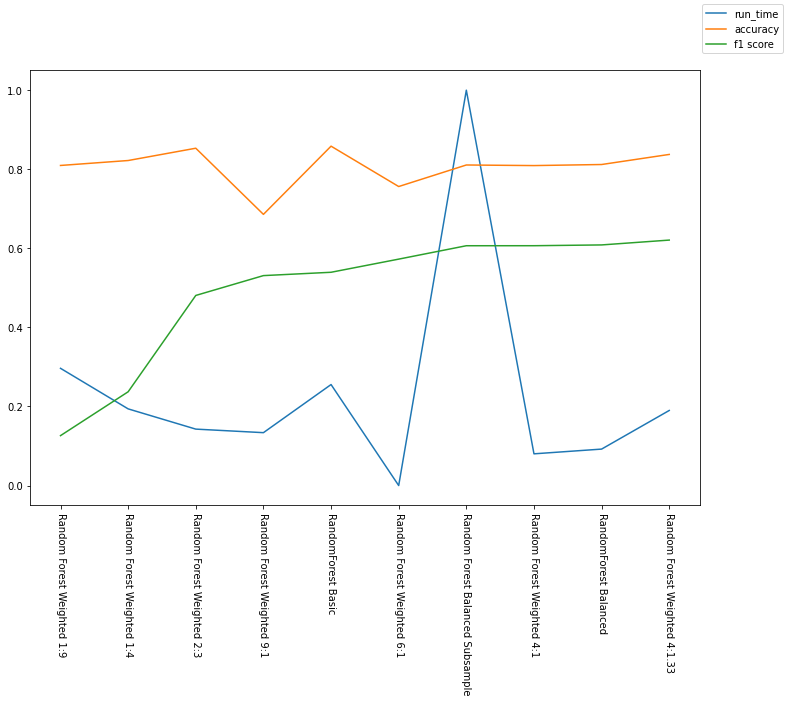

In [245]:
# Now check with the parameters obtained in the baseline
basic_models = [
    ('RandomForest Basic', lambda: RandomForestClassifier(random_state=1, criterion='entropy', min_samples_split=100, n_estimators=1000)),
    ('RandomForest Balanced', lambda: RandomForestClassifier(random_state=1, class_weight='balanced', criterion='entropy', min_samples_split=100, n_estimators=1000)),
    ('Random Forest Balanced Subsample', lambda: RandomForestClassifier(random_state=1, class_weight='balanced_subsample', criterion='entropy', min_samples_split=100, n_estimators=1000)),
    ('Random Forest Weighted 1:4', lambda: RandomForestClassifier(random_state=1, class_weight={1: 0.2, 0: 0.8}, criterion='entropy', min_samples_split=100, n_estimators=1000)),
    ('Random Forest Weighted 2:3', lambda: RandomForestClassifier(random_state=1, class_weight={1: 0.4, 0: 0.6}, criterion='entropy', min_samples_split=100, n_estimators=1000)),
    ('Random Forest Weighted 4:1', lambda: RandomForestClassifier(random_state=1, class_weight={1: 4, 0: 1}, criterion='entropy', min_samples_split=100, n_estimators=1000)),
    ('Random Forest Weighted 4:1.33', lambda: RandomForestClassifier(random_state=1, class_weight={1: 4, 0: 1.33}, criterion='entropy', min_samples_split=100, n_estimators=1000)),
    ('Random Forest Weighted 6:1', lambda: RandomForestClassifier(random_state=1, class_weight={1: 6, 0: 1}, criterion='entropy', min_samples_split=100, n_estimators=1000)),
    ('Random Forest Weighted 1:9', lambda: RandomForestClassifier(random_state=1, class_weight={1: 0.1, 0: 0.9}, criterion='entropy', min_samples_split=100, n_estimators=1000)),
    ('Random Forest Weighted 9:1', lambda: RandomForestClassifier(random_state=1, class_weight={1: 0.9, 0: 0.1}, criterion='entropy', min_samples_split=100, n_estimators=1000)),

]
compare_basic_models(run_basic_model, basic_models)

In [282]:
# Now plot with by varying the params
import copy
def compare_weighted_rfcs(X, y):
    """
    Compare the effect of alternate class weights on RFC
    """
    weights = []
    f1_scores = []
    acc_scores = []
    recall_scores = []
    precision_scores = []
    for i in np.arange(0, 1.1, 0.025):
        desc = "Random Forest: Weight = %f" % i
        if (1-i) > 0:
            cw = {1: i, 0: 1-i}
            rfc = RandomForestClassifier(random_state=1, class_weight=cw, criterion='entropy',\
                                                  min_samples_split=100, n_estimators=1000)
            rfc.fit(X, y)
            y_pred = cross_val_predict(rfc, X, y,\
                                       cv=model_selection.StratifiedKFold(n_splits=6, shuffle=True, random_state=2),\
                                       n_jobs=7)
            f1 = metrics.f1_score(y, y_pred)
            weights.append(i)
            f1_scores.append(f1)
            acc_scores.append(metrics.accuracy_score(y, y_pred))
            recall_scores.append(metrics.recall_score(y, y_pred))
            precision_scores.append(metrics.precision_score(y, y_pred))
            print("%8.4f %8.4f" % (i, f1, ))
    return weights, f1_scores, acc_scores, recall_scores, precision_scores

weights, f1_scores, acc_scores, rec_scores, prec_scores = compare_weighted_rfcs(scaled_X.to_numpy(), y.to_numpy())

  0.0000   0.0000
  0.0250   0.0281
  0.0500   0.0719
  0.0750   0.1051
  0.1000   0.1292
  0.1250   0.1453
  0.1500   0.1652
  0.1750   0.1869
  0.2000   0.2442
  0.2250   0.2861
  0.2500   0.3250
  0.2750   0.3644
  0.3000   0.3962
  0.3250   0.4174
  0.3500   0.4323
  0.3750   0.4487
  0.4000   0.4728
  0.4250   0.4925
  0.4500   0.5101
  0.4750   0.5285
  0.5000   0.5434
  0.5250   0.5610
  0.5500   0.5713
  0.5750   0.5810
  0.6000   0.5909
  0.6250   0.5986
  0.6500   0.6094
  0.6750   0.6161
  0.7000   0.6239
  0.7250   0.6277
  0.7500   0.6252
  0.7750   0.6191
  0.8000   0.6067
  0.8250   0.5973
  0.8500   0.5828
  0.8750   0.5571
  0.9000   0.5296
  0.9250   0.4953
  0.9500   0.4563
  0.9750   0.4123


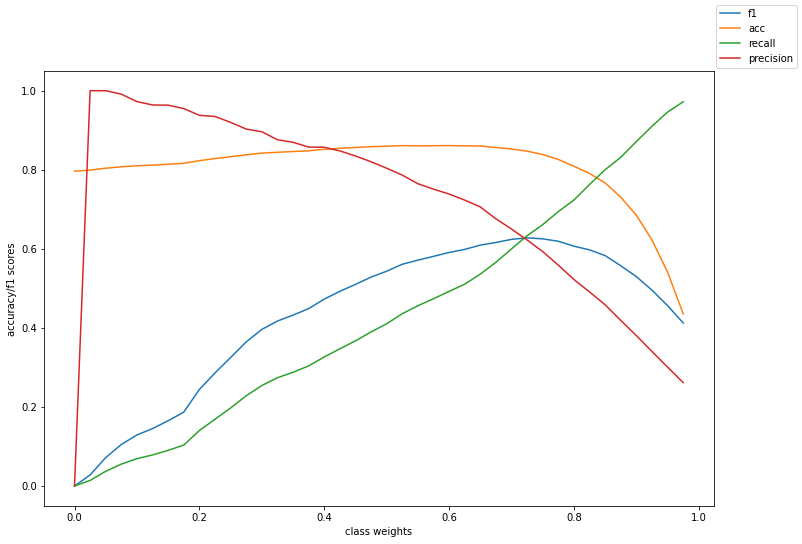

In [284]:
fig, ax = plt.subplots()
ax.plot(weights, f1_scores, label='f1')
ax.plot(weights, acc_scores, label='acc')
ax.plot(weights, rec_scores, label="recall")
ax.plot(weights, prec_scores, label="precision")
ax.set_xlabel('class weights')
ax.set_ylabel('accuracy/f1 scores')
fig.legend()

In [288]:
for i, j, k, l, m in zip(weights, f1_scores, acc_scores, rec_scores, prec_scores):
    print("weight = %4.2f | f1 = %5.4f | accuracy = %5.4f | recall = %5.4f | precision = %5.4f" % (i, j, k, l, m))

weight = 0.00 | f1 = 0.0000 | accuracy = 0.7963 | recall = 0.0000 | precision = 0.0000
weight = 0.03 | f1 = 0.0281 | accuracy = 0.7992 | recall = 0.0142 | precision = 1.0000
weight = 0.05 | f1 = 0.0719 | accuracy = 0.8039 | recall = 0.0373 | precision = 1.0000
weight = 0.08 | f1 = 0.1051 | accuracy = 0.8075 | recall = 0.0555 | precision = 0.9912
weight = 0.10 | f1 = 0.1292 | accuracy = 0.8100 | recall = 0.0692 | precision = 0.9724
weight = 0.12 | f1 = 0.1453 | accuracy = 0.8117 | recall = 0.0785 | precision = 0.9639
weight = 0.15 | f1 = 0.1652 | accuracy = 0.8140 | recall = 0.0903 | precision = 0.9634
weight = 0.18 | f1 = 0.1869 | accuracy = 0.8164 | recall = 0.1036 | precision = 0.9548
weight = 0.20 | f1 = 0.2442 | accuracy = 0.8230 | recall = 0.1404 | precision = 0.9377
weight = 0.23 | f1 = 0.2861 | accuracy = 0.8283 | recall = 0.1689 | precision = 0.9348
weight = 0.25 | f1 = 0.3250 | accuracy = 0.8330 | recall = 0.1973 | precision = 0.9199
weight = 0.28 | f1 = 0.3644 | accuracy = 0.

#### Grid Search different weights (no SMOTE) <a class='anchor' id='GridSearchRFCWeighted'></a>

In [243]:
# Try a grid wearch with different weights, and with some other parameters
def grid_search_random_forest_weighted(X, y):
    rfc = RandomForestClassifier(random_state=1)
    p = imblearn.pipeline.Pipeline([('rfc', rfc)])
    
    class_weights = [{0: i, 1: 1-i} for i in np.arange(0, 1, 0.05)]
    class_weights.append({1: 4, 0: 1.33})
    class_weights.append({1: 4, 0: 1})
    class_weights.append({1: 5, 0: 1})
    param_grid = {
        'rfc__n_estimators': [10, 100, 1000],
        'rfc__criterion': ['gini', 'entropy'],
        'rfc__min_samples_split': [i for i in range(20, 200, 40)],
        'rfc__class_weight': class_weights
    }
    #scoring = {'F1': make_scorer(metrics.f1_score), 'ACC': make_scorer(metrics.accuracy_score)}
    scorer = make_scorer(metrics.f1_score)
    cv1 = StratifiedKFold(n_splits=6, random_state=10, shuffle=True)
    search = GridSearchCV(p, param_grid, n_jobs=7, cv=cv1, scoring=scorer)
    search.fit(X, y)
    print("RANDOM FOREST")
    print(f"Best Params = {search.best_params_}")
    print(f"Best score = {search.best_score_}")
    print('-' * 120)
    return search.best_estimator_

random.seed(22)
rfcw  = grid_search_random_forest_weighted(scaled_X.to_numpy(), y.to_numpy())

RANDOM FOREST
Best Params = {'rfc__class_weight': {0: 0.2, 1: 0.8}, 'rfc__criterion': 'gini', 'rfc__min_samples_split': 20, 'rfc__n_estimators': 100}
Best score = 0.6323982569024459
------------------------------------------------------------------------------------------------------------------------


#### GridSearch BalancedRandomForestClassifier from Imblearn <a class='anchor' id='GSBalancedRFC'></a>

In [276]:
def grid_search_balanced_random_forest_weighted(X, y):
    rfc = BalancedRandomForestClassifier(random_state=1)
    p = imblearn.pipeline.Pipeline([('rfc', rfc)])
    
    param_grid = {
        'rfc__n_estimators': [10, 100, 1000],
        'rfc__criterion': ['gini', 'entropy'],
        'rfc__min_samples_split': [i for i in range(20, 200, 40)],
        'rfc__class_weight': [{0: i, 1: 1-i} for i in np.arange(0, 1, 0.1)],
        'rfc__bootstrap': [True, False],
        'rfc__oob_score': [True, False],
    }
    #scoring = {'F1': make_scorer(metrics.f1_score), 'ACC': make_scorer(metrics.accuracy_score)}
    scorer = make_scorer(metrics.f1_score)
    cv1 = StratifiedKFold(n_splits=6, random_state=10, shuffle=True)
    search = GridSearchCV(p, param_grid, n_jobs=7, cv=cv1, scoring=scorer)
    search.fit(X, y)
    print("RANDOM FOREST")
    print(f"Best Params = {search.best_params_}")
    print(f"Best score = {search.best_score_}")
    print('-' * 120)
    return search.best_estimator_


random.seed(22)
bwrfc  = grid_search_balanced_random_forest_weighted(scaled_X.to_numpy(), y.to_numpy())

RANDOM FOREST
Best Params = {'rfc__bootstrap': True, 'rfc__class_weight': {0: 0.7000000000000001, 1: 0.29999999999999993}, 'rfc__criterion': 'entropy', 'rfc__min_samples_split': 20, 'rfc__n_estimators': 100, 'rfc__oob_score': True}
Best score = 0.6329106408569257
------------------------------------------------------------------------------------------------------------------------


#### Random Forest with Adjusted Cutoff <a class='anchor' id='RFAdjustedCutoff'></a>

In [290]:
def random_forest_alternate_cutoff(X, y, cutoff, use_smote=False):
    """
    Using Alternate cut-off is different from assigning class weights. Assigning class weights
    actually changes the mode, but this doens't change the model.
    The only thing that changes is that we predict a probability instead of a definite value,
    and then set a cut-off on that probability.
    """
    f1_scores = []
    accuracy_scores = []
    recall_scores = []
    precision_scores = []
    kf = model_selection.StratifiedKFold(n_splits=6, shuffle=True, random_state=2)
    for train_index, test_index in kf.split(X, y):
        rfc = RandomForestClassifier(random_state=0, class_weight='balanced_subsample', criterion='entropy', min_samples_split=100, n_estimators=1000, n_jobs=7)
        X_train, y_train = X[train_index, :], y[train_index]
        X_test, y_test = X[test_index, :], y[test_index]
        if use_smote:
            sm = SMOTE()
            X_train, y_train = sm.fit_resample(X_train, y_train)
        rfc.fit(X_train, y_train)
        y_pred_proba = rfc.predict_proba(X_test)
        y_pred = (y_pred_proba[:, 1] >= cutoff).astype('int')
        f1s = metrics.f1_score(y_test, y_pred)
        accs = metrics.accuracy_score(y_test, y_pred)
        f1_scores.append(f1s)
        recall_scores.append(metrics.recall_score(y_test, y_pred))
        precision_scores.append(metrics.precision_score(y_test, y_pred))
        accuracy_scores.append(accs)
    return mean(accuracy_scores), mean(f1_scores), mean(recall_scores), mean(precision_scores)

   0.00000         0.2036999563         0.3384562867         0.2036999563         1.0000000000
   0.05000         0.2160994572         0.3417630524         0.2061432254         0.9990196078
   0.10000         0.2948994235         0.3644404072         0.2232327069         0.9921481867
   0.15000         0.3781006104         0.3912567866         0.2443955141         0.9808534328
   0.20000         0.4621009172         0.4228523914         0.2706232485         0.9671149286
   0.25000         0.5438002436         0.4581976529         0.3022398960         0.9469879692
   0.30000         0.6196992894         0.4932123362         0.3385166326         0.9086977269
   0.35000         0.6860987346         0.5298961211         0.3812581525         0.8689325583
   0.40000         0.7391995791         0.5636000164         0.4274662791         0.8271863613
   0.45000         0.7834007028         0.5938122218         0.4804228219         0.7776100411
   0.50000         0.8109996848         0.60772374

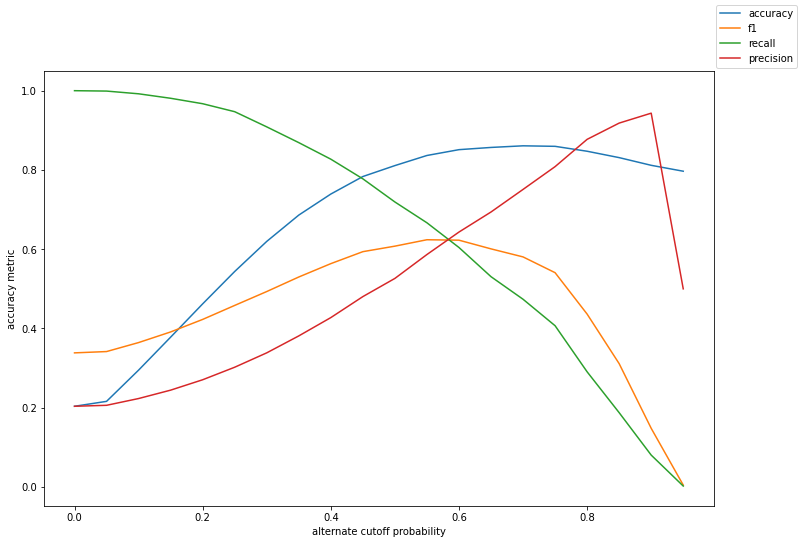

In [295]:
acc_scores = []
f1_scores = []
rec_scores = []
prec_scores = []
cutoffs = []
for i in np.arange(0, 1, 0.05):
    accs, f1s, rec, prec = random_forest_alternate_cutoff(scaled_X.to_numpy(), y.to_numpy(), i)
    acc_scores.append(accs)
    f1_scores.append(f1s)
    rec_scores.append(rec)
    prec_scores.append(prec)
    cutoffs.append(i)

for i, j, k, l, m in zip(cutoffs, acc_scores, f1_scores, prec_scores, rec_scores):
    print("%10.5f %20.10f %20.10f %20.10f %20.10f" % (i, j, k, l, m))
fig, ax = plt.subplots()
ax.plot(cutoffs, acc_scores, label="accuracy")
ax.plot(cutoffs, f1_scores, label="f1")
ax.plot(cutoffs, rec_scores, label="recall")
ax.plot(cutoffs, prec_scores, label="precision")
ax.set_xlabel('alternate cutoff probability')
ax.set_ylabel('accuracy metric')
fig.legend()

Do a more fine grained one with a smalle rinterval

   0.50000         0.8109996848         0.6077237432         0.2036999563         1.0000000000
   0.51000         0.8163995052         0.6113544138         0.2061432254         0.9990196078
   0.52000         0.8226993257         0.6164340182         0.2232327069         0.9921481867
   0.53000         0.8271995661         0.6188813431         0.2443955141         0.9808534328
   0.54000         0.8305992463         0.6182805793         0.2706232485         0.9671149286
   0.55000         0.8364991467         0.6239149352         0.3022398960         0.9469879692
   0.56000         0.8399995871         0.6249520083         0.3385166326         0.9086977269
   0.57000         0.8444997675         0.6277714194         0.3812581525         0.8689325583
   0.58000         0.8463995676         0.6250138357         0.4274662791         0.8271863613
   0.59000         0.8492999479         0.6242401350         0.4804228219         0.7776100411


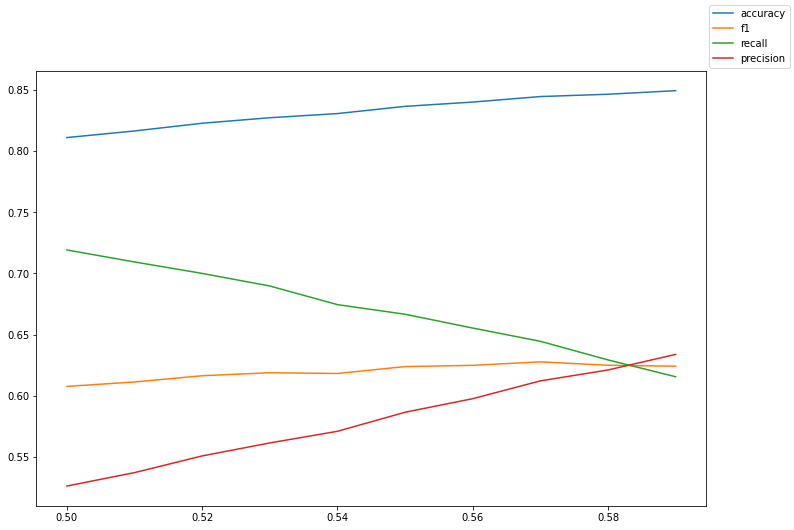

In [297]:
acc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
cutoffs = []
for i in np.arange(0.50, 0.60, 0.01):
    accs, f1s, rec, prec = random_forest_alternate_cutoff(scaled_X.to_numpy(), y.to_numpy(), i)
    acc_scores.append(accs)
    f1_scores.append(f1s)
    recall_scores.append(rec)
    precision_scores.append(prec)
    cutoffs.append(i)

for i, j, k, l, m in zip(cutoffs, acc_scores, f1_scores, prec_scores, rec_scores):
    print("%10.5f %20.10f %20.10f %20.10f %20.10f" % (i, j, k, l, m))
fig, ax = plt.subplots()
ax.plot(cutoffs, acc_scores, label="accuracy")
ax.plot(cutoffs, f1_scores, label="f1")
ax.plot(cutoffs, recall_scores, label="recall")
ax.plot(cutoffs, precision_scores, label="precision")
fig.legend()

Do a more fine-grained for a smaller interval, use SMOTE this time

0.45    0.81860    0.61310
0.46    0.82330    0.61544
0.47    0.82580    0.61486
0.48    0.82930    0.61650
0.49    0.83210    0.61591
0.50    0.83510    0.61746
0.51    0.83700    0.61707
0.52    0.83990    0.61611
0.53    0.84490    0.62261
0.54    0.84480    0.61607
0.55    0.84600    0.61504


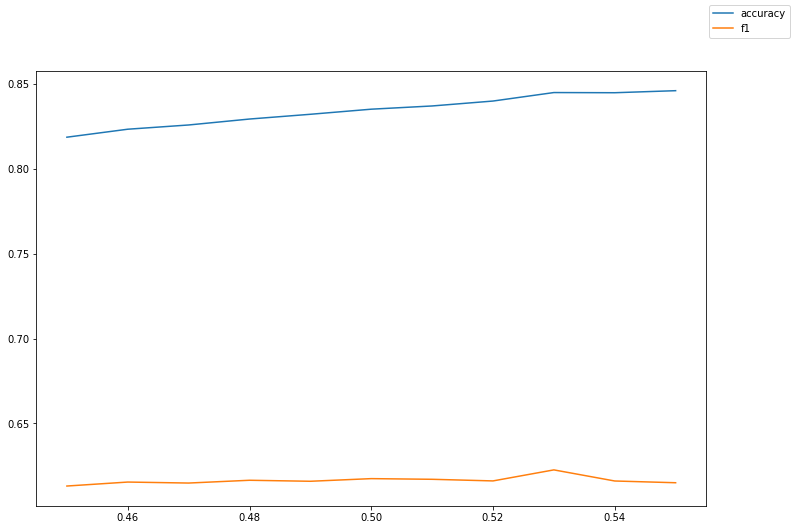

In [343]:
acc_scores = []
f1_scores = []
cutoffs = []
for i in np.arange(0.45, 0.55, 0.01):
    accs, f1s = random_forest_alternate_cutoff(scaled_X.to_numpy(), y.to_numpy(), i, use_smote=True)
    acc_scores.append(accs)
    f1_scores.append(f1s)
    cutoffs.append(i)

for i, j, k in zip(cutoffs, acc_scores, f1_scores):
    print("%3.2f %10.5f %10.5f" % (i, j, k))
fig, ax = plt.subplots()
ax.plot(cutoffs, acc_scores, label="accuracy")
ax.plot(cutoffs, f1_scores, label="f1")
fig.legend()

#### Classification with Other Samplers (over-samplers and combine-samplers) <a class='anchor' id='ClassificationSamplerComparison'></a>

In [84]:
def all_models_compare_samplers2(X, y, sampler, description, model_gen_fn, model_description):
    if None != sampler:
        p = imblearn.pipeline.Pipeline([('sampler', sampler), ('model', model_gen_fn())])
    else:
        p = model_gen_fn()
    y_pred = cross_val_predict(p, X, y, \
                               cv=model_selection.StratifiedKFold(n_splits=6, shuffle=True, random_state=2),\
                               n_jobs=7)
    print(f"Description: {description} Model: {model_description}\n{metrics.classification_report(y, y_pred)}")
    print('-' * 80)
    return metrics.accuracy_score(y, y_pred), metrics.f1_score(y, y_pred)

--------------------------------------------------------------------------------
ITERATING FOR GRADIENTBOOSTING

Description: NONE Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      7963
           1       0.78      0.47      0.59      2037

    accuracy                           0.86     10000
   macro avg       0.83      0.72      0.75     10000
weighted avg       0.86      0.86      0.85     10000

--------------------------------------------------------------------------------
Description: RandomOversampling Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      7963
           1       0.51      0.74      0.60      2037

    accuracy                           0.80     10000
   macro avg       0.72      0.78      0.74     10000
weighted avg       0.84      0.80      0.81     10000

------------------------------------------------------

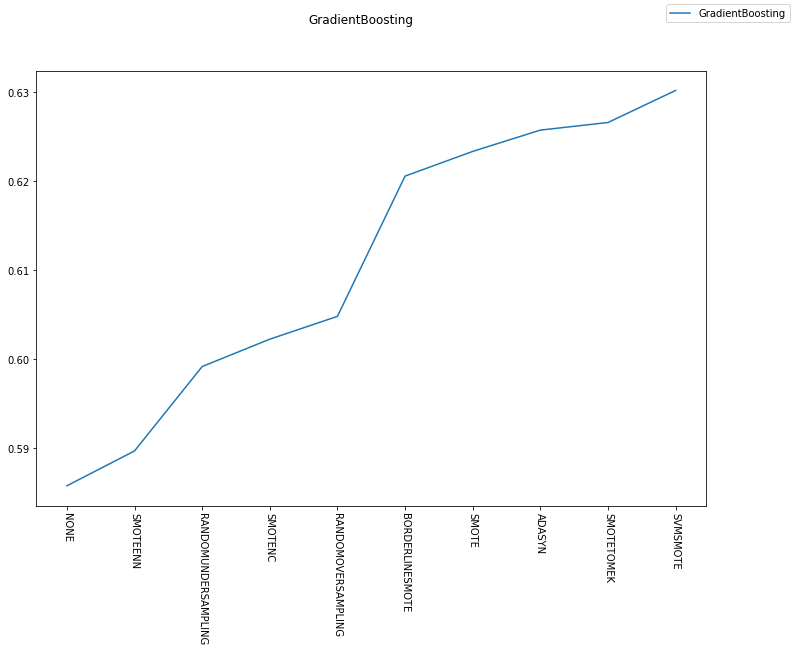

EVALUATING MODEL GradientBoosting
------
                NONE    0.86480    0.58578
            smoteenn    0.78250    0.58970
 RandomUnderSampling    0.79290    0.59919
             smotenc    0.80690    0.60227
  RandomOversampling    0.80190    0.60483
     borderlinesmote    0.83090    0.62060
               smote    0.84110    0.62337
              adasyn    0.84140    0.62577
          smotetomek    0.84150    0.62662
            svmsmote    0.83900    0.63023
----------------------------------------

--------------------------------------------------------------------------------
ITERATING FOR RANDOMFOREST

Description: NONE Model: RandomForest
              precision    recall  f1-score   support

           0       0.92      0.83      0.88      7963
           1       0.53      0.72      0.61      2037

    accuracy                           0.81     10000
   macro avg       0.72      0.78      0.74     10000
weighted avg       0.84      0.81      0.82     10000

-------------

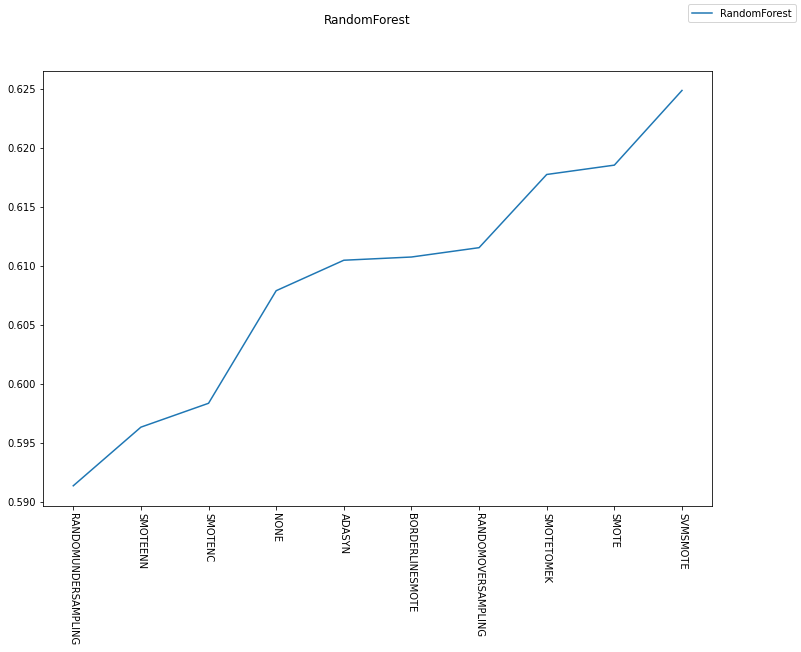

EVALUATING MODEL GradientBoosting
------
                NONE    0.86480    0.58578
            smoteenn    0.78250    0.58970
 RandomUnderSampling    0.79290    0.59919
             smotenc    0.80690    0.60227
  RandomOversampling    0.80190    0.60483
     borderlinesmote    0.83090    0.62060
               smote    0.84110    0.62337
              adasyn    0.84140    0.62577
          smotetomek    0.84150    0.62662
            svmsmote    0.83900    0.63023
----------------------------------------
EVALUATING MODEL RandomForest
------
 RandomUnderSampling    0.78840    0.59135
            smoteenn    0.79610    0.59632
             smotenc    0.81110    0.59834
                NONE    0.81100    0.60788
              adasyn    0.82210    0.61047
     borderlinesmote    0.81950    0.61074
  RandomOversampling    0.81540    0.61153
          smotetomek    0.83490    0.61774
               smote    0.83570    0.61853
            svmsmote    0.83310    0.62486
---------------------

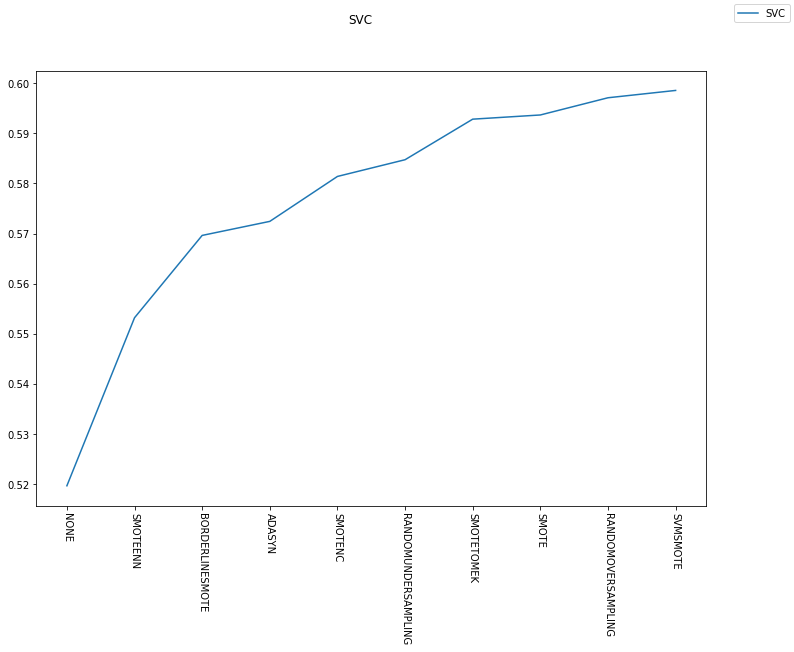

EVALUATING MODEL GradientBoosting
------
                NONE    0.86480    0.58578
            smoteenn    0.78250    0.58970
 RandomUnderSampling    0.79290    0.59919
             smotenc    0.80690    0.60227
  RandomOversampling    0.80190    0.60483
     borderlinesmote    0.83090    0.62060
               smote    0.84110    0.62337
              adasyn    0.84140    0.62577
          smotetomek    0.84150    0.62662
            svmsmote    0.83900    0.63023
----------------------------------------
EVALUATING MODEL RandomForest
------
 RandomUnderSampling    0.78840    0.59135
            smoteenn    0.79610    0.59632
             smotenc    0.81110    0.59834
                NONE    0.81100    0.60788
              adasyn    0.82210    0.61047
     borderlinesmote    0.81950    0.61074
  RandomOversampling    0.81540    0.61153
          smotetomek    0.83490    0.61774
               smote    0.83570    0.61853
            svmsmote    0.83310    0.62486
---------------------

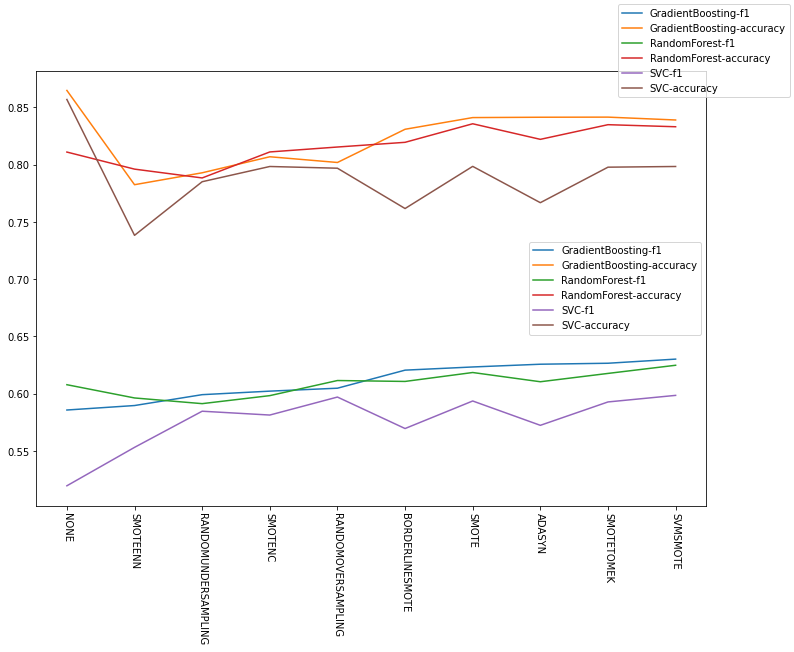

In [117]:
"""For each sampler, and for each model, see the performance of the combination
This just calls the function to compare, but the rest of the code is just for plotting
a graph.
"""

samplers = [
    ('NONE', None),
    ('RandomOversampling', RandomOverSampler(sampling_strategy='minority')),
    ('RandomUnderSampling', RandomUnderSampler(sampling_strategy='majority')),
    ('smote', SMOTE(random_state=0)),
    ('adasyn', ADASYN(random_state=0)),
    ('smotenc', SMOTENC([False, False, True, True, True, True, False, True, True, True, True, True], random_state=0)),
    ('borderlinesmote', BorderlineSMOTE(random_state=0)),
    ('svmsmote', SVMSMOTE(random_state=0)),
    ('smoteenn', SMOTEENN(random_state=0)),
    ('smotetomek', SMOTETomek(random_state=0))
]

models = [
    ('GradientBoosting', lambda: GradientBoostingClassifier(random_state=0, max_depth=3, min_samples_split=42, n_estimators=100)),
    ('RandomForest', lambda: RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', max_depth=None, min_samples_split=100, n_estimators=1000, random_state=0)),
    ('SVC', lambda: SVC(class_weight=None, gamma='auto', kernel='rbf', random_state=0)),
]
descriptions = []
sorted_indices = None
indices_calculated = False
comparison_string = ""

plot_data = []
for a, b in models:
    fig1, ax1 = plt.subplots()
    accuracy_scores = []
    f1_scores = []
    descriptions = []
    print('-' * 80)
    print(f"ITERATING FOR {a.upper()}\n")
    for i, j in samplers:
        accs, f1s = all_models_compare_samplers2(scaled_X.to_numpy(), y.to_numpy(), j, i, b, a)
        accuracy_scores.append(accs)
        f1_scores.append(f1s)
        descriptions.append(i)
    if False == indices_calculated:
        sorted_indices = np.argsort(f1_scores)
        indices_calculated = True
    plot_data.append(([f1_scores[i] for i in sorted_indices], f"{a}-f1",) )
    plot_data.append(([accuracy_scores[i] for i in sorted_indices], f'{a}-accuracy',))
    ax1.plot([f1_scores[i] for i in np.argsort(f1_scores)], label=a)
    plt.xticks(np.arange(0, len(f1_scores), 1.0))
    ax1.set_xticklabels([descriptions[i].upper() for i in np.argsort(f1_scores)], rotation=270)
    fig1.legend()
    fig1.suptitle(a)
    plt.show()
    sorted_order = np.argsort(f1_scores)
    comparison_string += "EVALUATING MODEL %s\n" % a
    comparison_string += '------\n'
    for i in sorted_order:
        comparison_string += "%20s %10.5f %10.5f" % (descriptions[i], accuracy_scores[i], f1_scores[i])
        comparison_string += "\n"
    comparison_string += "----------------------------------------\n"
    print(comparison_string)
fig, ax = plt.subplots()
plt.xticks(np.arange(0, len(f1_scores), 1.0))
for array, lab in plot_data:
    ax.plot(array, label=lab)
ax.set_xticklabels([descriptions[i].upper() for i in sorted_indices], rotation=270)
ax.legend()
fig.legend()

print(plot_data)

#### Classifiers Samplers and Feature-Selectors compared <a class='anchor' id='ClassifierSamplerSelectorCompared'></a>

In [100]:
def model_compare_3(X, y,\
                    sampler, description,\
                    model_gen_fn, model_description,\
                    feature_selector_fn, feature_selector_description):
    p = []
    if None != sampler:
        p.append(('sampler', sampler,))
    if None != feature_selector_fn:
        p.append(('fs', feature_selector_fn(),))
    p.append(('model', model_gen_fn(),))
    p = imblearn.pipeline.Pipeline(p)
    y_pred = cross_val_predict(p, X, y, \
                               cv=model_selection.StratifiedKFold(n_splits=6, shuffle=True, random_state=2),\
                               n_jobs=7)
    print(f"Description: {description} Model: {model_description}\n{metrics.classification_report(y, y_pred)}")
    print('-' * 80)
    return metrics.accuracy_score(y, y_pred), metrics.f1_score(y, y_pred)

In [244]:
"""Earlier we had just combined models with samplers.
Here we will combine models, samplers and feature selectors and see the output"""

selectors = [
    ('Variance Threshold 0.8', lambda: VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('RFECV RandomForest', lambda: RFECV(estimator=RandomForestClassifier())),
    ('FWE f_classif', lambda: SelectFwe(f_classif, alpha=0.01)),
    ('NONE', None),
]


samplers = [
    ('smote', SMOTE(random_state=0)),
    ('adasyn', ADASYN(random_state=0)),
    ('svmsmote', SVMSMOTE(random_state=0)),
    ('smotetomek', SMOTETomek(random_state=0)),
    ('RandomOversampling', RandomOverSampler(sampling_strategy='minority')),
    ('NONE', None)
]

models = [
    ('GradientBoosting', lambda: GradientBoostingClassifier(random_state=0, max_depth=3, min_samples_split=42, n_estimators=100)),
    ('RandomForest', lambda: RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', max_depth=None, min_samples_split=100, n_estimators=1000, random_state=0)),
    ('SVC', lambda: SVC(class_weight=None, gamma='auto', kernel='rbf', random_state=0)),
]

all_descs = ""
all_results = []
for model_desc, model_fn in models:
    for sampler_desc, sampler in samplers:
        for selector_desc, selector in selectors:
            print('-'*80)
            print("EVALUATING: ", model_desc, sampler_desc, selector_desc)
            acc, f1 = model_compare_3(scaled_X.to_numpy(), y.to_numpy(),\
                                     sampler, sampler_desc,\
                                     model_fn, model_desc,\
                                     selector, selector_desc)
            print("%20s %30s %30s %20.10f %20.10f" % (model_desc, sampler_desc, selector_desc, acc, f1))
            all_descs += "%20s %30s %30s %20.10f %20.10f" % (model_desc, sampler_desc, selector_desc, acc, f1)
            all_descs += '\n'
            all_results.append((model_desc, sampler_desc, selector_desc, acc, f1,))
print(all_descs)

    

--------------------------------------------------------------------------------
EVALUATING:  GradientBoosting smote Variance Threshold 0.8
Description: smote Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7963
           1       0.60      0.65      0.62      2037

    accuracy                           0.84     10000
   macro avg       0.76      0.77      0.76     10000
weighted avg       0.85      0.84      0.84     10000

--------------------------------------------------------------------------------
    GradientBoosting                          smote         Variance Threshold 0.8         0.8411000000         0.6233704669
--------------------------------------------------------------------------------
EVALUATING:  GradientBoosting smote RFECV RandomForest
Description: smote Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7

Description: smotetomek Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7963
           1       0.60      0.65      0.63      2037

    accuracy                           0.84     10000
   macro avg       0.76      0.77      0.76     10000
weighted avg       0.85      0.84      0.84     10000

--------------------------------------------------------------------------------
    GradientBoosting                     smotetomek         Variance Threshold 0.8         0.8415000000         0.6266195524
--------------------------------------------------------------------------------
EVALUATING:  GradientBoosting smotetomek RFECV RandomForest
Description: smotetomek Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7963
           1       0.61      0.65      0.63      2037

    accuracy                           0.84     10000
   macro avg

Description: smote Model: RandomForest
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      7963
           1       0.59      0.65      0.62      2037

    accuracy                           0.84     10000
   macro avg       0.75      0.77      0.76     10000
weighted avg       0.84      0.84      0.84     10000

--------------------------------------------------------------------------------
        RandomForest                          smote         Variance Threshold 0.8         0.8357000000         0.6185279777
--------------------------------------------------------------------------------
EVALUATING:  RandomForest smote RFECV RandomForest
Description: smote Model: RandomForest
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      7963
           1       0.59      0.66      0.62      2037

    accuracy                           0.84     10000
   macro avg       0.75      0.77      

Description: smotetomek Model: RandomForest
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      7963
           1       0.58      0.65      0.62      2037

    accuracy                           0.83     10000
   macro avg       0.75      0.77      0.76     10000
weighted avg       0.84      0.83      0.84     10000

--------------------------------------------------------------------------------
        RandomForest                     smotetomek         Variance Threshold 0.8         0.8349000000         0.6177355869
--------------------------------------------------------------------------------
EVALUATING:  RandomForest smotetomek RFECV RandomForest
Description: smotetomek Model: RandomForest
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      7963
           1       0.59      0.66      0.62      2037

    accuracy                           0.84     10000
   macro avg       0.75 

Description: smote Model: SVC
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      7963
           1       0.50      0.72      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg       0.84      0.80      0.81     10000

--------------------------------------------------------------------------------
                 SVC                          smote         Variance Threshold 0.8         0.7985000000         0.5936680782
--------------------------------------------------------------------------------
EVALUATING:  SVC smote RFECV RandomForest
Description: smote Model: SVC
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      7963
           1       0.50      0.72      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg

Description: smotetomek Model: SVC
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      7963
           1       0.50      0.72      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.77      0.73     10000
weighted avg       0.84      0.80      0.81     10000

--------------------------------------------------------------------------------
                 SVC                     smotetomek         Variance Threshold 0.8         0.7978000000         0.5928312525
--------------------------------------------------------------------------------
EVALUATING:  SVC smotetomek RFECV RandomForest
Description: smotetomek Model: SVC
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      7963
           1       0.50      0.72      0.59      2037

    accuracy                           0.80     10000
   macro avg       0.71      0.77      0.73     100

In [90]:
all_f1s = []
for model_desc, sampler_desc, selector_desc, acc, f1 in all_results:
    all_f1s.append(f1)
sorted_indices = np.argsort(all_f1s)[::-1]
print("%20s %22s %25s %10s %10s" % ('ALGORITHM', 'SAMPLING', 'FEATURE-SELECTION', 'ACC', 'F1'))
print("%20s %22s %25s %10s %10s" % ('-'*20, '-'*22,  '-'*25, '-'*10, '-'*10))
for i in sorted_indices:
    model_desc, sampler_desc, selector_desc, acc, f1 = all_results[i]
    print("%20s %22s %25s %10.5f %10.5f" % (model_desc, sampler_desc, selector_desc, acc, f1))

           ALGORITHM               SAMPLING         FEATURE-SELECTION        ACC         F1
-------------------- ---------------------- ------------------------- ---------- ----------
    GradientBoosting               svmsmote    Variance Threshold 0.8    0.83900    0.63023
    GradientBoosting               svmsmote                      NONE    0.83900    0.63023
    GradientBoosting               svmsmote        RFECV RandomForest    0.83850    0.62933
    GradientBoosting               svmsmote             FWE f_classif    0.83240    0.62904
        RandomForest             smotetomek             FWE f_classif    0.83650    0.62832
        RandomForest               svmsmote             FWE f_classif    0.83210    0.62829
    GradientBoosting             smotetomek    Variance Threshold 0.8    0.84150    0.62662
    GradientBoosting             smotetomek                      NONE    0.84150    0.62662
    GradientBoosting             smotetomek        RFECV RandomForest    0.84140

 Here we can see that applying variance-threshold feature selection and no feature selection gave the exact same results. This is because no feature was eliminated.

In [99]:
"""Variance Treshold feature selection and No feature selection gave identical output
in case of GradientBoost. We want to verify if this was because variance threshold
actually thought that al features were important"""
selectors = [
    ('NONE', None),
]

for i in np.arange(0, 1.01, 0.05):
    selectors.append(('Variance Threshold %f' % i, lambda: VarianceThreshold(i * (1-i)),))
    



model = lambda: GradientBoostingClassifier(random_state=0, max_depth=3, min_samples_split=42, n_estimators=100)

all_descs2 = ""
all_results2 = []
for selector_desc, selector in selectors:
    model_desc = "GradientBoosting"
    sampler_desc = "svmsmote"
    print('-'*80)
    print("EVALUATING: ", model_desc, sampler_desc, selector_desc)
    acc, f1 = model_compare_3(scaled_X.to_numpy(), y.to_numpy(),\
                             SVMSMOTE(random_state=0), 'svmsmote',\
                             model, 'gradient-boosting',\
                             selector, selector_desc)
    print("%20s %30s %30s %20.10f %20.10f" % (model_desc, sampler_desc, selector_desc, acc, f1))
    all_descs2 += "%20s %30s %30s %20.10f %20.10f" % (model_desc, sampler_desc, selector_desc, acc, f1)
    all_descs2 += '\n'
    all_results2.append((model_desc, sampler_desc, selector_desc, acc, f1,))


    print(all_descs2) 

--------------------------------------------------------------------------------
EVALUATING:  GradientBoosting svmsmote NONE
Description: svmsmote Model: gradient-boosting
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      7963
           1       0.59      0.67      0.63      2037

    accuracy                           0.84     10000
   macro avg       0.75      0.78      0.76     10000
weighted avg       0.85      0.84      0.84     10000

--------------------------------------------------------------------------------
    GradientBoosting                       svmsmote                           NONE         0.8390000000         0.6302250804
--------------------------------------------------------------------------------
EVALUATING:  GradientBoosting svmsmote Variance Threshold 0.000000
Description: svmsmote Model: gradient-boosting
              precision    recall  f1-score   support

           0       0.91      0.88      0.90  

Description: svmsmote Model: gradient-boosting
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      7963
           1       0.59      0.67      0.63      2037

    accuracy                           0.84     10000
   macro avg       0.75      0.78      0.76     10000
weighted avg       0.85      0.84      0.84     10000

--------------------------------------------------------------------------------
    GradientBoosting                       svmsmote    Variance Threshold 0.550000         0.8390000000         0.6302250804
--------------------------------------------------------------------------------
EVALUATING:  GradientBoosting svmsmote Variance Threshold 0.600000
Description: svmsmote Model: gradient-boosting
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      7963
           1       0.59      0.67      0.63      2037

    accuracy                           0.84     10000
   macr

#### RUSBOOST (Boost + UnderSampling at each stage) <a class='anchor' id='rusboost'></a>

In [180]:
# Perform grid search in two stages to reduce the number of combinations required
from imblearn.ensemble import RUSBoostClassifier

def search_rus_boost(X, y):
    rusbc = RUSBoostClassifier(random_state=0)
    p = [('rusbc', rusbc,)]
    p = imblearn.pipeline.Pipeline(p)
    param_grid = {
        'rusbc__n_estimators': [1000, 10000],
        'rusbc__learning_rate': [1, 0.1, 0.01, 0.001],
        'rusbc__algorithm': ['SAMME', 'SAMME.R'],
    }
    scorer = make_scorer(metrics.f1_score)
    cv1 = StratifiedKFold(n_splits=6, random_state=10, shuffle=True)
    search = GridSearchCV(p, param_grid, n_jobs=7, cv=cv1, scoring=scorer)
    search.fit(X, y)
    print("GRADIENT BOOSTING")
    print(f"Best Params = {search.best_params_}")
    print(f"Best score = {search.best_score_}")
    print('-' * 120)
    return search.best_estimator_

rusboost = search_rus_boost(scaled_X.to_numpy(), y.to_numpy())

GRADIENT BOOSTING
Best Params = {'rusbc__algorithm': 'SAMME.R', 'rusbc__learning_rate': 0.001, 'rusbc__n_estimators': 10000}
Best score = 0.5837437094271175
------------------------------------------------------------------------------------------------------------------------


In [181]:
from imblearn.ensemble import RUSBoostClassifier

def search_rus_boost(X, y):
    rusbc = RUSBoostClassifier(random_state=0)
    p = [('rusbc', rusbc,)]
    p = imblearn.pipeline.Pipeline(p)
    param_grid = {
        'rusbc__n_estimators': [10000, 100000],
        'rusbc__learning_rate': [0.001, 0.0001],
        'rusbc__algorithm': ['SAMME.R'],
    }
    scorer = make_scorer(metrics.f1_score)
    cv1 = StratifiedKFold(n_splits=6, random_state=10, shuffle=True)
    search = GridSearchCV(p, param_grid, n_jobs=7, cv=cv1, scoring=scorer)
    search.fit(X, y)
    print("GRADIENT BOOSTING")
    print(f"Best Params = {search.best_params_}")
    print(f"Best score = {search.best_score_}")
    print('-' * 120)
    return search.best_estimator_

rusboost = search_rus_boost(scaled_X.to_numpy(), y.to_numpy())

GRADIENT BOOSTING
Best Params = {'rusbc__algorithm': 'SAMME.R', 'rusbc__learning_rate': 0.001, 'rusbc__n_estimators': 100000}
Best score = 0.5847328429438647
------------------------------------------------------------------------------------------------------------------------
